<a href="https://colab.research.google.com/github/Vinooj/Data-Engineering-for-ETL/blob/main/DE_with_dlt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Engineering for ETL: Data Ingestion with dlt**

While building the simple pipeline, Alexey had to manually handle **nested API calls**, **validate** and **transform** the data, define **schema**, and ensure proper **storage** in multiple formats. This process involved writing and debugging considerable boilerplate code, especially for managing API interactions and database integration. In this section, **we introduce dlt**, a tool that automates much of this work, including data typing, schema inference, and streamlined data ingestion, allowing you to focus on higher-level tasks.

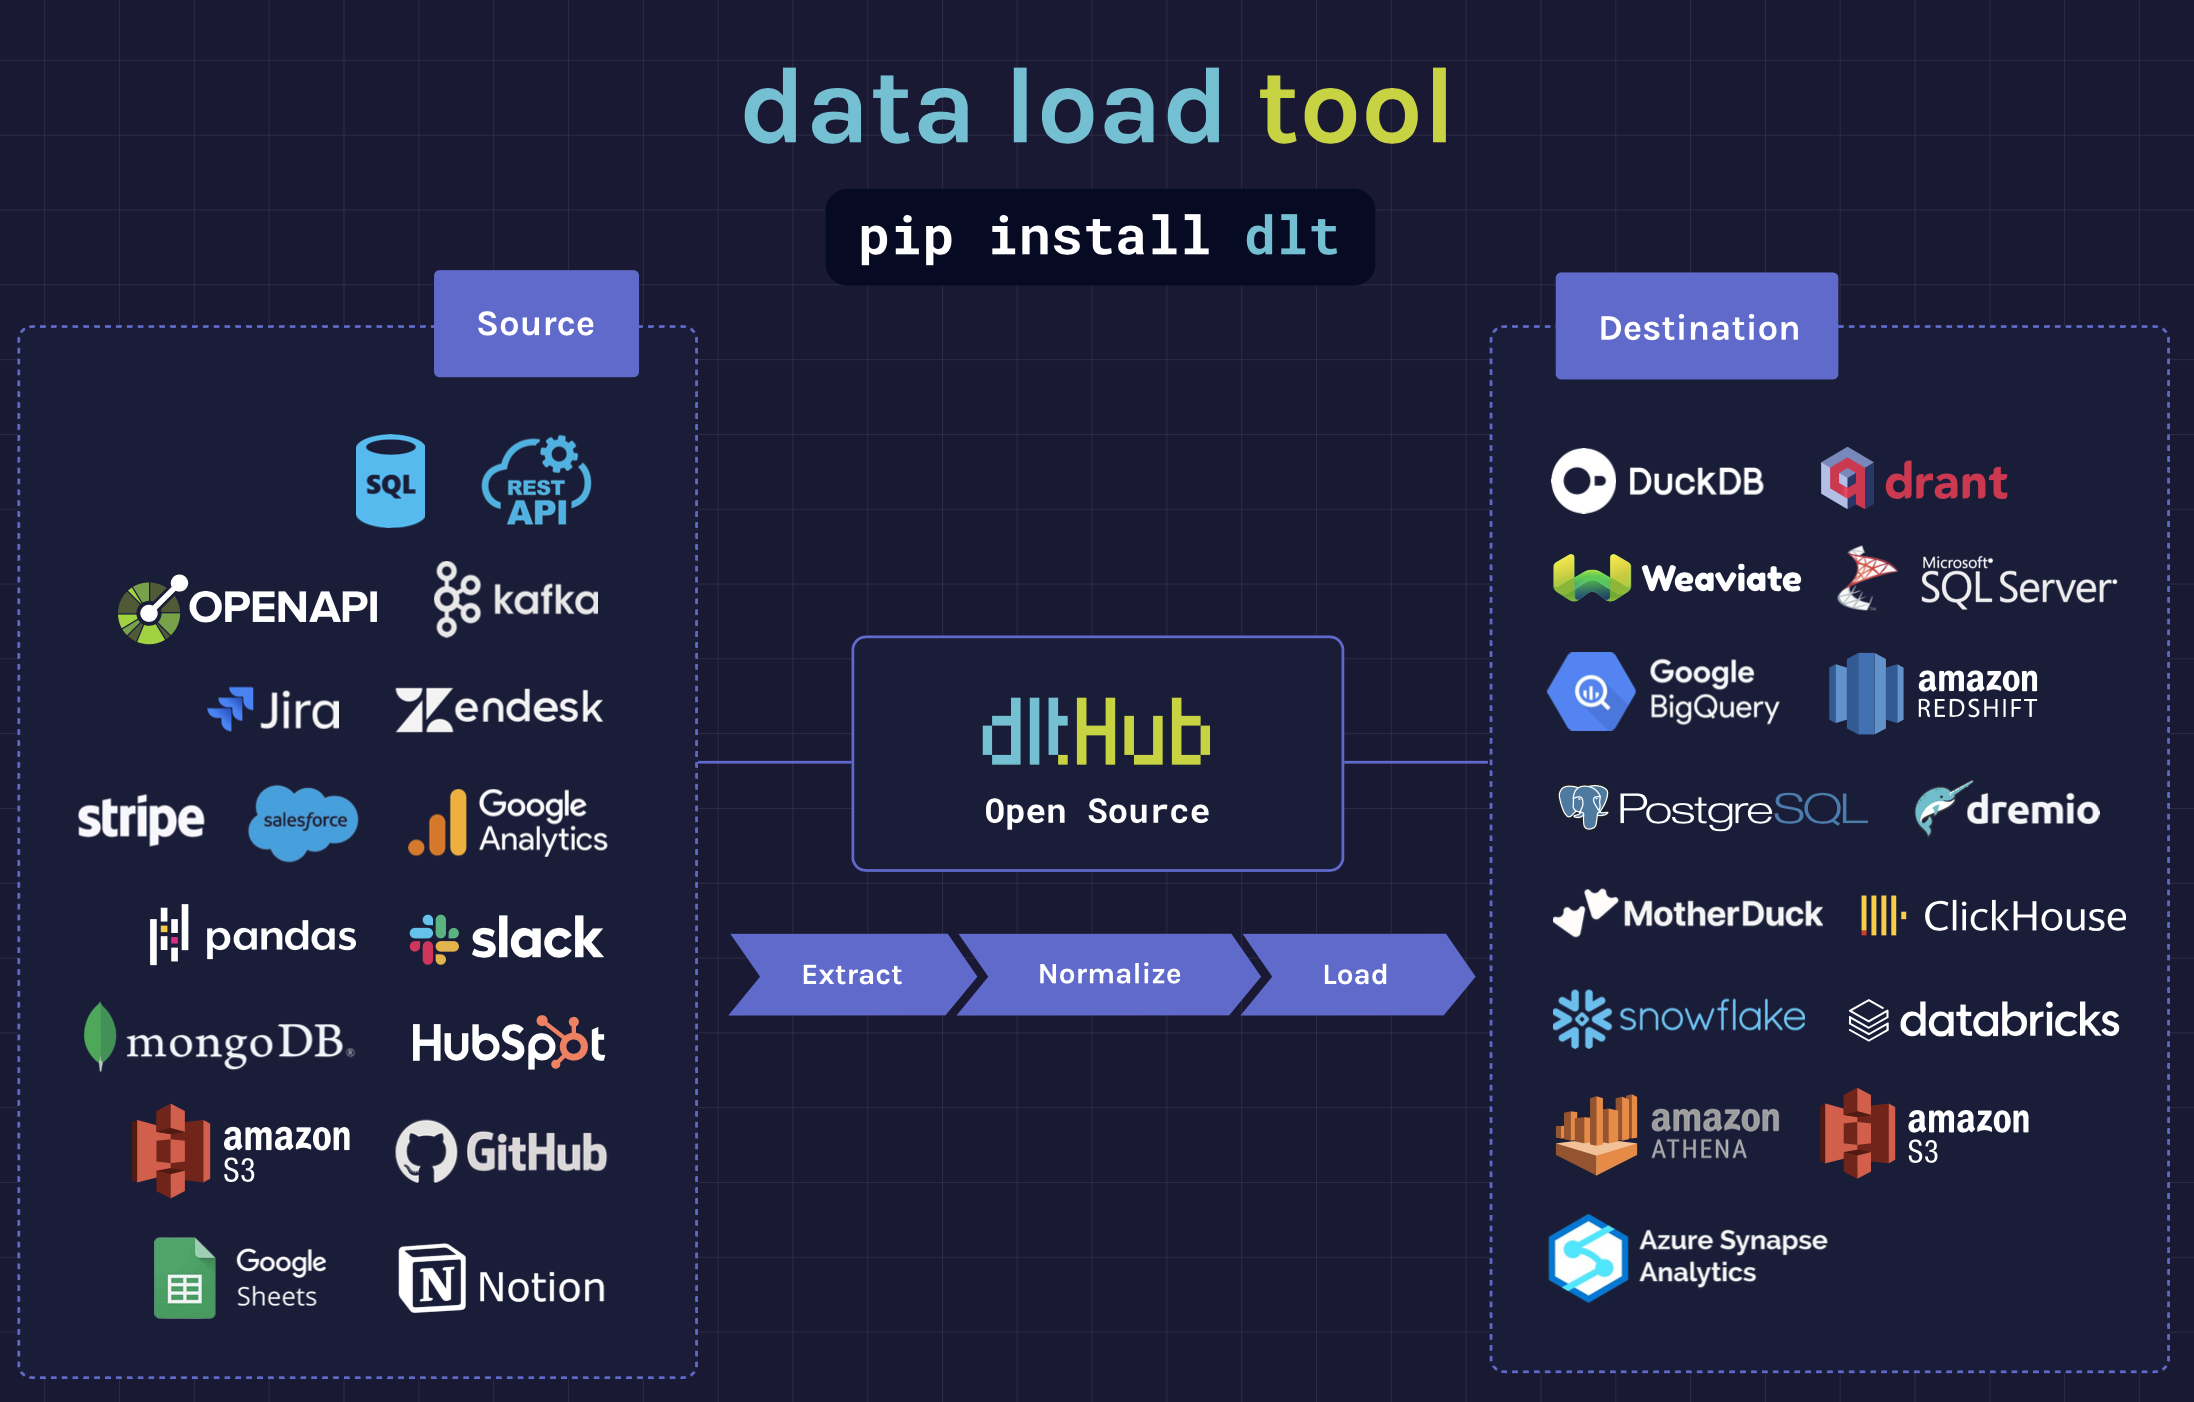

## **Introduction to dlt**

> "Why reinvent the wheel?"


**Goal:** Replace the manual pipeline built in the previous section with a streamlined pipeline powered by **dlt**. By leveraging dlt’s built-in features, you’ll see how to simplify data extraction, transformation, and loading with minimal boilerplate code.

1. **What is dlt?**
    - An open-source Python library that makes it easy to build data pipelines.
    - Simplifies data loading by handling schema management, incremental updates, retries, and more.
    - Similar to how dbt democratized the T layer of ELT with SQL, dltHub democratizes EL with Python.

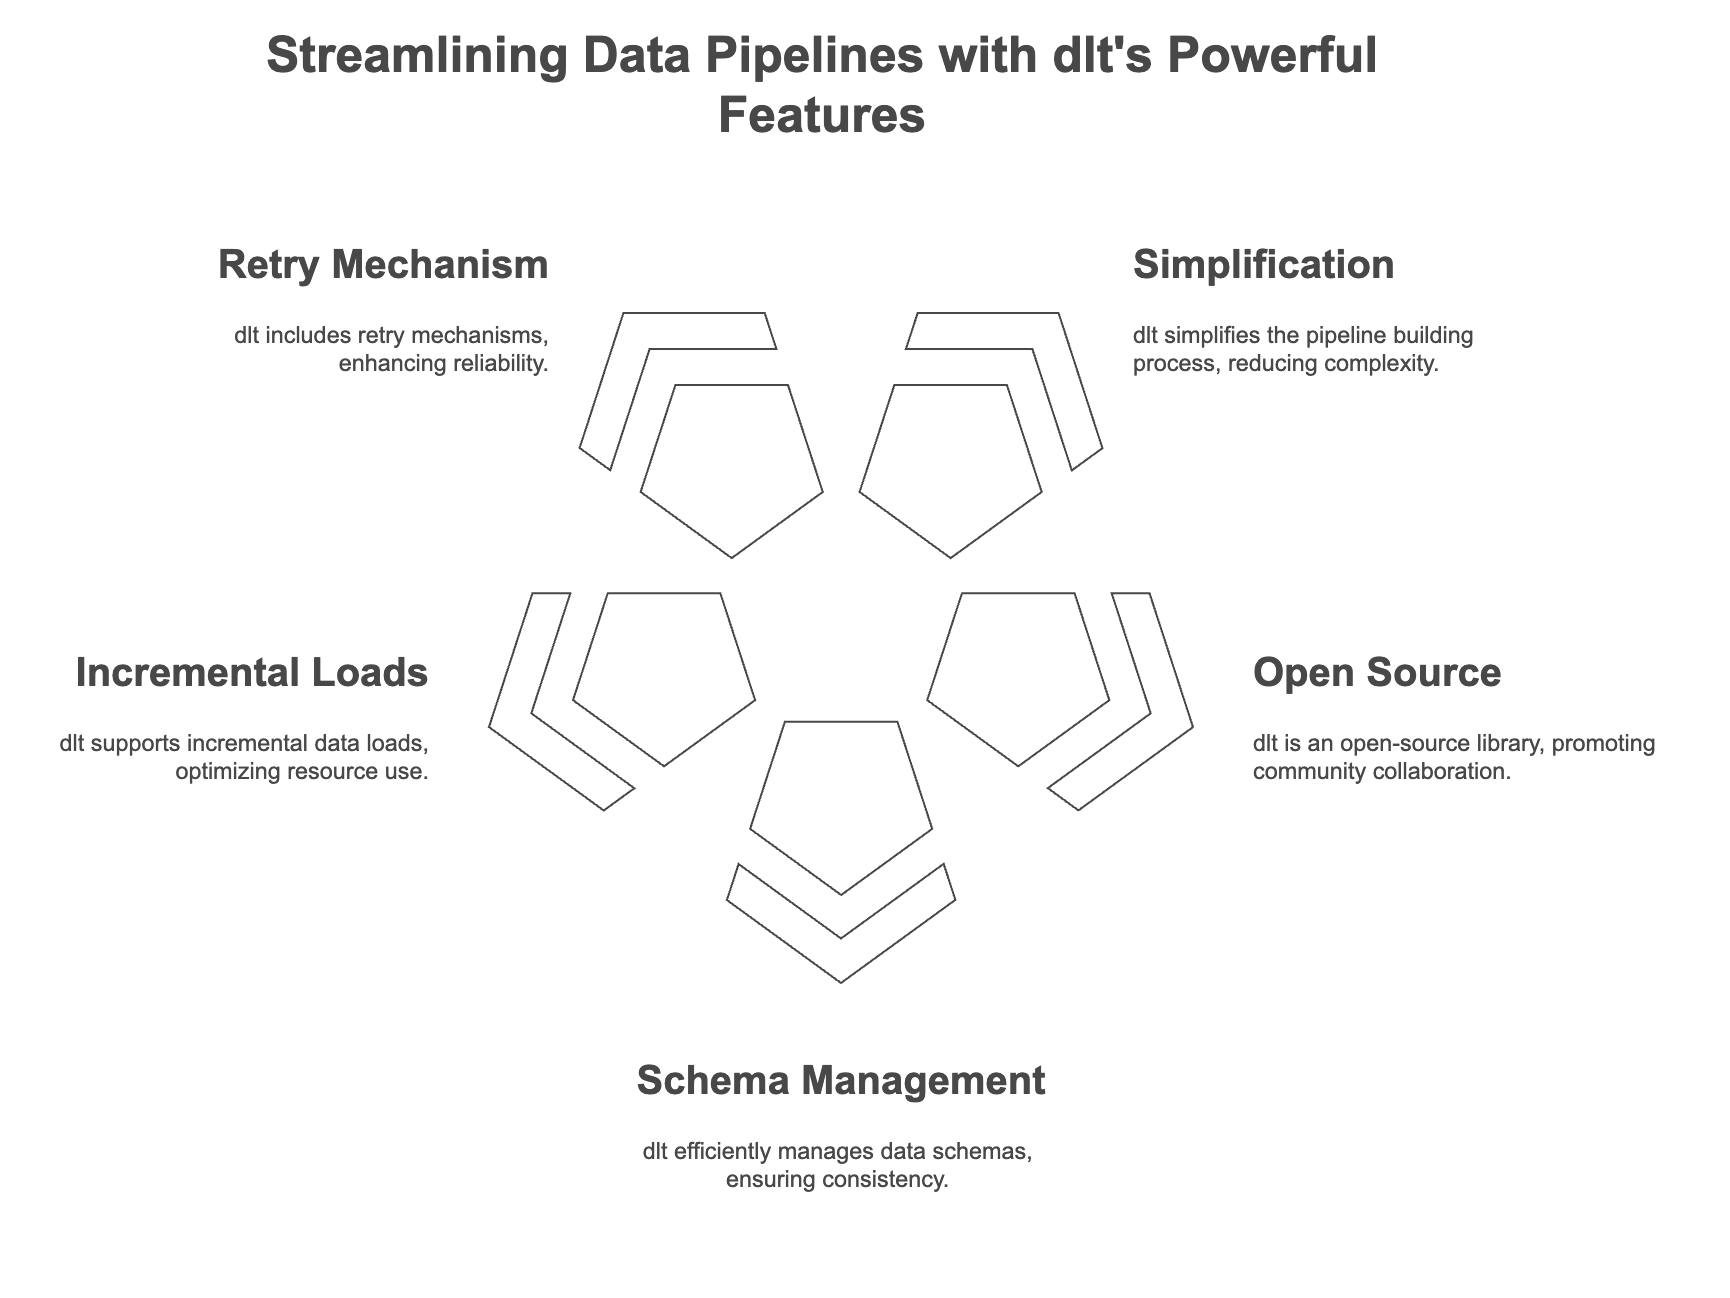

## **Install dlt**
[Install](https://dlthub.com/docs/reference/installation) dlt with DuckDB as destination:

In [1]:
%%capture
!pip install dlt[duckdb]

## **Extracting data with dlt**

Extracting data from APIs manually requires handling
- **pagination**,
- **rate limits**,
- **authentication**,
- **errors**.

Instead of writing custom scripts, **[dlt](https://dlthub.com/)** simplifies the process with a built-in **[REST API Client](https://dlthub.com/docs/general-usage/http/rest-client)**, making extraction **efficient, scalable, and reliable**.  

---

### **Why use dlt for extraction?**  

✅ **Built-in REST API support** – Extract data from APIs with minimal code.  
✅ **Automatic pagination handling** – No need to loop through pages manually.  
✅ **Manages Rate Limits & Retries** – Prevents exceeding API limits and handles failures.  
✅ **Streaming support** – Extracts and processes data without loading everything into memory.  
✅ **Seamless integration** – Works with **normalization and loading** in a single pipeline.  



### **Example: extracting data with dlt**  

Instead of manually writing pagination logic, let’s use **dlt’s [`RESTClient` helper](https://dlthub.com/docs/general-usage/http/rest-client)** to extract events data.

Let's first recall how data extraction from API was implemented without dlt.

#### Recap: In the previous part

📌 Example:

>In this example, we’ll request data from [GitHub API](https://docs.github.com/en/rest/quickstart?apiVersion=2022-11-28).

When calling a GitHub API endpoint, such as fetching events from the `data-engineering-zoomcamp` repository, GitHub paginates the results, meaning it returns only a limited number of records per request. By default, this is **30 results per page**, even if more data is available. To get all results, we need to request additional pages until there are no more left.

**API [documentation](https://docs.github.com/en/rest/activity/events?apiVersion=2022-11-28#list-repository-events)**:  
- **Endpoint**: `/repos/{owner}/{repo}/events`, lists repository events.
- **Data**: List of dicts. Comes in pages of 30 records.  
- **Pagination**: When there’s no more data, the API returns no links to the next page.  
- **Details**:  
  - **Method**: GET  
  - **URL**: `https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp/events`  
  - **Parameters**:  
    - `page`: Integer (page number), defaults to 1.
    - `per_page`: The number of results per page (max 100). Defaults to 30.  

>When a response is paginated, the response headers will include a `link` header. If the endpoint does not support pagination, or if all results fit on a single page, the link header will be omitted.
>
>The link header contains URLs that you can use to fetch additional pages of results. For example, the previous, next, first, and last page of results.


This script demonstrates how to handle paginated responses by automatically requesting the next page of data until all pages are retrieved:

In [1]:
import requests
from google.colab import userdata

API_TOKEN = userdata.get('GITHUB_API_TOKEN')
BASE_URL = "https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp/events"


def paginated_getter():
    page_number = 1
    url = BASE_URL

    # Iterate over pages
    while True:
        # Starts at **page 1** and makes a **GET request** to the API.
        response = requests.get(url, headers={"Authorization": f"Bearer {API_TOKEN}"})
        # Retrieves **JSON data**.
        page_data = response.json()
        yield page_data

        # Looks for the **"next" page URL** in the response headers.
        next_page = response.links.get("next", {}).get("url")


        # If there’s **no next page**, stops fetching and ends the loop.
        if not next_page:
            break

        # If a **next page exists**, updates `BASE_URL` and requests more data.
        page_number += 1
        url = next_page


for page_data in paginated_getter():
    print(page_data)

[{'id': '48966350677', 'type': 'ForkEvent', 'actor': {'id': 79210846, 'login': 'Kaung-Si-Thu', 'display_login': 'Kaung-Si-Thu', 'gravatar_id': '', 'url': 'https://api.github.com/users/Kaung-Si-Thu', 'avatar_url': 'https://avatars.githubusercontent.com/u/79210846?'}, 'repo': {'id': 419661684, 'name': 'DataTalksClub/data-engineering-zoomcamp', 'url': 'https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp'}, 'payload': {'forkee': {'id': 971292775, 'node_id': 'R_kgDOOeTAZw', 'name': 'data-engineering-zoomcamp', 'full_name': 'Kaung-Si-Thu/data-engineering-zoomcamp', 'private': False, 'owner': {'login': 'Kaung-Si-Thu', 'id': 79210846, 'node_id': 'MDQ6VXNlcjc5MjEwODQ2', 'avatar_url': 'https://avatars.githubusercontent.com/u/79210846?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Kaung-Si-Thu', 'html_url': 'https://github.com/Kaung-Si-Thu', 'followers_url': 'https://api.github.com/users/Kaung-Si-Thu/followers', 'following_url': 'https://api.github.com/users/Kaung-

**What happens here:**  

- Starts at **page 1** and makes a **GET request** to the API.  
- Retrieves **JSON data**.  
- Looks for the **"next" page URL** in the response headers.  
- If a **next page exists**, updates `BASE_URL` and requests more data.  
- If there’s **no next page**, stops fetching and ends the loop.

In [4]:
import dlt
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator
from google.colab import userdata

API_TOKEN = userdata.get('GITHUB_API_TOKEN')

def paginated_getter():
    client = RESTClient(
        base_url="https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp/",
        auth=BearerTokenAuth(token=API_TOKEN),
        paginator=HeaderLinkPaginator(links_next_key="next"),
    )

    for page in client.paginate("events"):    # <--- API endpoint for retrieving events data
        yield page   # remember about memory management and yield data


for page_data in paginated_getter():
    print(page_data)

[{'id': '48966350677', 'type': 'ForkEvent', 'actor': {'id': 79210846, 'login': 'Kaung-Si-Thu', 'display_login': 'Kaung-Si-Thu', 'gravatar_id': '', 'url': 'https://api.github.com/users/Kaung-Si-Thu', 'avatar_url': 'https://avatars.githubusercontent.com/u/79210846?'}, 'repo': {'id': 419661684, 'name': 'DataTalksClub/data-engineering-zoomcamp', 'url': 'https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp'}, 'payload': {'forkee': {'id': 971292775, 'node_id': 'R_kgDOOeTAZw', 'name': 'data-engineering-zoomcamp', 'full_name': 'Kaung-Si-Thu/data-engineering-zoomcamp', 'private': False, 'owner': {'login': 'Kaung-Si-Thu', 'id': 79210846, 'node_id': 'MDQ6VXNlcjc5MjEwODQ2', 'avatar_url': 'https://avatars.githubusercontent.com/u/79210846?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Kaung-Si-Thu', 'html_url': 'https://github.com/Kaung-Si-Thu', 'followers_url': 'https://api.github.com/users/Kaung-Si-Thu/followers', 'following_url': 'https://api.github.com/users/Kaung-



**How dlt simplifies API extraction:**  

🔹 **No manual pagination** – dlt **automatically** fetches **all pages** of data.  
🔹 **Low memory usage** – Streams data **chunk by chunk**, avoiding RAM overflows.  
🔹 **Handles rate limits & retries** – Ensures requests are sent efficiently **without failures**.  
🔹 **Flexible destination support** – Load extracted data into **databases, warehouses, or data lakes**.  


### **dlt Resources**



To use all the power of dlt is better to wrap our API Client in the `@dlt.resource` decorator which denotes a logical grouping of data within a data source, typically holding data of similar structure and origin:

In [5]:
import dlt
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator
from google.colab import userdata

API_TOKEN = userdata.get('GITHUB_API_TOKEN')


@dlt.resource(name="events") # <--- The name of the resource (will be used as the table name)
def paginated_getter():
    client = RESTClient(
        base_url="https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp/",
        auth=BearerTokenAuth(token=API_TOKEN),
        paginator=HeaderLinkPaginator(links_next_key="next"),
    )

    for page in client.paginate("events"):
        yield page


for page_data in paginated_getter():
    print(page_data)

{'id': '48966350677', 'type': 'ForkEvent', 'actor': {'id': 79210846, 'login': 'Kaung-Si-Thu', 'display_login': 'Kaung-Si-Thu', 'gravatar_id': '', 'url': 'https://api.github.com/users/Kaung-Si-Thu', 'avatar_url': 'https://avatars.githubusercontent.com/u/79210846?'}, 'repo': {'id': 419661684, 'name': 'DataTalksClub/data-engineering-zoomcamp', 'url': 'https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp'}, 'payload': {'forkee': {'id': 971292775, 'node_id': 'R_kgDOOeTAZw', 'name': 'data-engineering-zoomcamp', 'full_name': 'Kaung-Si-Thu/data-engineering-zoomcamp', 'private': False, 'owner': {'login': 'Kaung-Si-Thu', 'id': 79210846, 'node_id': 'MDQ6VXNlcjc5MjEwODQ2', 'avatar_url': 'https://avatars.githubusercontent.com/u/79210846?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Kaung-Si-Thu', 'html_url': 'https://github.com/Kaung-Si-Thu', 'followers_url': 'https://api.github.com/users/Kaung-Si-Thu/followers', 'following_url': 'https://api.github.com/users/Kaung-S

Commonly used arguments:

* **`name`**: The resource name and the name of the table generated by this resource. Defaults to the decorated function name.
* **`table_name`**: the name of the table, if different from the resource name.
* **`write_disposition`**: controls how to write data to a table. Defaults to "append".

> **Why is it a better way?** This allows you to use `dlt` functionalities to the fullest that follow Data Engineering best practices, including incremental loading and data contracts.

### **dlt configuration and secrets**

In dlt, [configurations and secrets](https://dlthub.com/docs/general-usage/credentials/) are essential for setting up data pipelines.

**Configurations** are **non-sensitive** settings that define the behavior of a data pipeline, including file paths, database hosts, timeouts, API URLs, and performance settings.

On the other hand, **secrets** are **sensitive** data like passwords, API keys, and private keys, which should never be hard-coded to avoid security risks.

These can be set up in various ways:

* Environment variables
* In code using `dlt.secrets` and `dlt.config`
* Configuration files (`secrets.toml` and `config.toml`)

We're gonna use `dlt.secrets.value` to define credentials in resources and sources. dlt automatically **extracts** configuration settings and secrets based on flexible naming conventions. It then **injects** these values where needed in code.

**Note**: It's important to note that while you can put all configurations and credentials in the `dlt.secrets` (or `secrets.toml`) if it's more convenient, credentials cannot be placed in `dlt.config` (or `config.toml`) because dlt doesn't look for them there.


In [2]:
import os
import dlt
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator
from google.colab import userdata

os.environ["ACCESS_TOKEN"] = userdata.get('GITHUB_API_TOKEN') # <--- set ENV in the special format: uppercase secret name

# Just for debuggiong
# api_key = os.environ.get('ACCESS_TOKEN')
# print (api_key)


# IMPORTANT: Inorder for this code to work in Google collab, you need to restrat the session ( runtime -> restart Session )
#            and it will work.

@dlt.resource(name="events")
def paginated_getter(
    access_token=dlt.secrets.value,  # <--- set the secret variable "access_token" here
):
    client = RESTClient(
        base_url="https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp/",
        auth=BearerTokenAuth(token=access_token), # <--- use the variable "access_token" as usual
        paginator=HeaderLinkPaginator(links_next_key="next"),
    )

    for page in client.paginate("events"):
        yield page


for page_data in paginated_getter():
    print(page_data)

{'id': '48966350677', 'type': 'ForkEvent', 'actor': {'id': 79210846, 'login': 'Kaung-Si-Thu', 'display_login': 'Kaung-Si-Thu', 'gravatar_id': '', 'url': 'https://api.github.com/users/Kaung-Si-Thu', 'avatar_url': 'https://avatars.githubusercontent.com/u/79210846?'}, 'repo': {'id': 419661684, 'name': 'DataTalksClub/data-engineering-zoomcamp', 'url': 'https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp'}, 'payload': {'forkee': {'id': 971292775, 'node_id': 'R_kgDOOeTAZw', 'name': 'data-engineering-zoomcamp', 'full_name': 'Kaung-Si-Thu/data-engineering-zoomcamp', 'private': False, 'owner': {'login': 'Kaung-Si-Thu', 'id': 79210846, 'node_id': 'MDQ6VXNlcjc5MjEwODQ2', 'avatar_url': 'https://avatars.githubusercontent.com/u/79210846?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/Kaung-Si-Thu', 'html_url': 'https://github.com/Kaung-Si-Thu', 'followers_url': 'https://api.github.com/users/Kaung-Si-Thu/followers', 'following_url': 'https://api.github.com/users/Kaung-S

## **Normalizing data with dlt**  

**Why Use dlt for normalization?**  

✅ **Automatically detects schema** – No need to define column types manually.  
✅ **Flattens nested JSON** – Converts complex structures into table-ready formats.  
✅ **Handles data type conversion** – Converts dates, numbers, and booleans correctly.  
✅ **Splits lists into child tables** – Ensures relational integrity for better analysis.  
✅ **Schema evolution support** – Adapts to changes in data structure over time.  

---

### **Example**  

Let's extract events data, which contains **nested dictionaries** and **lists** (PullRequestEvent contains lists):  


In [ ]:
page_data[0]

{'id': '46576418685',
 'type': 'WatchEvent',
 'actor': {'id': 4998809,
  'login': 'eskrav',
  'display_login': 'eskrav',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/eskrav',
  'avatar_url': 'https://avatars.githubusercontent.com/u/4998809?'},
 'repo': {'id': 419661684,
  'name': 'DataTalksClub/data-engineering-zoomcamp',
  'url': 'https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp'},
 'payload': {'action': 'started'},
 'public': True,
 'created_at': '2025-02-14T11:12:09Z',
 'org': {'id': 72699292,
  'login': 'DataTalksClub',
  'gravatar_id': '',
  'url': 'https://api.github.com/orgs/DataTalksClub',
  'avatar_url': 'https://avatars.githubusercontent.com/u/72699292?'}}

### **How dlt normalizes this data automatically**  

Instead of manually flattening fields and extracting nested lists, we can **load it directly into DuckDB**:

In [ ]:
import dlt

# Define a dlt pipeline with automatic normalization
pipeline = dlt.pipeline(
    pipeline_name="github_data",
    destination="duckdb",
    dataset_name="events",
)

# Run the pipeline with raw nested data
info = pipeline.run(page_data, table_name="events", write_disposition="replace") # <--- LOAD ONLY THE LAST PAGE "page_data"

# Print the load summary
print(info)

Pipeline github_data load step completed in 0.94 seconds
1 load package(s) were loaded to destination duckdb and into dataset events
The duckdb destination used duckdb:////content/github_data.duckdb location to store data
Load package 1740142475.8137922 is LOADED and contains no failed jobs


Note:
* **Replace**: This disposition replaces the data in the destination with the data from the resource. It **deletes** all the data and **recreates** the schema before loading the data.

When running a data pipeline, logs provide critical insights into how data moves through the process. Let's take a look at dlt pipeline last trace:

In [ ]:
print(pipeline.last_trace)

Run started at 2025-02-21 12:54:35.644331+00:00 and COMPLETED in 2.26 seconds with 4 steps.
Step extract COMPLETED in 0.06 seconds.

Load package 1740142475.8137922 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.19 seconds.
Normalized data for the following tables:
- events: 27 row(s)
- events__payload__pull_request__base__repo__topics: 48 row(s)
- _dlt_pipeline_state: 1 row(s)

Load package 1740142475.8137922 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 1.84 seconds.
Pipeline github_data load step completed in 0.94 seconds
1 load package(s) were loaded to destination duckdb and into dataset events
The duckdb destination used duckdb:////content/github_data.duckdb location to store data
Load package 1740142475.8137922 is LOADED and contains no failed jobs

Step run COMPLETED in 2.26 seconds.
Pipeline github_data load step completed in 0.94 seconds
1 load package(s) w

---

### **Understanding dlt trace**  

1. **Run start & duration** → The pipeline started at **12:54:35 UTC** and **completed in 2.26 seconds** with 4 steps.  

  - **Extract step** → Pulled data from the source **in 0.06 seconds**, creating a **load package** that is extracted but not yet loaded.  

  - **Normalization step** → Processed and **flattened nested data**, creating **three structured tables** in **0.19 seconds**.  

  - **Load step** → Data was written to **DuckDB (`github_data.duckdb`)** in **1.84 seconds**, the longest step.  

2. **Successful Completion** → No failed jobs, **1 load package fully processed**.  

3. **Schema evolution in action** → The **`events__payload__pull_request__base__repo__topics`** table indicates dlt automatically **handles nested data**.  



After running this pipeline, dlt automatically **transforms the data** into the following **normalized structure**:  

- **Main table:** `events`
- **Child table:** `events__payload__pull_request__base__repo__topics`
- **Special table:** `_dlt_pipeline_state`


> The `_dlt_pipeline_state` table, created by the dlt library in the destination dataset, stores the state of your pipeline. It contains information about the pipeline, the pipeline run, and a serialized version of the pipeline state.

Now, let's check which tables were created using:

In [ ]:
pipeline.dataset(dataset_type="default").schema.data_table_names()

['events', 'events__payload__pull_request__base__repo__topics']

This returns only two tables, but where is `_dlt_pipeline_state`?
Why is it not listed, and how does dlt manage system tables differently from user tables?

`_dlt_pipeline_state` is a system table, and dlt separates data tables from internal metadata tables. To list system tables, use:

In [ ]:
pipeline.dataset(dataset_type="default").schema.dlt_table_names()

['_dlt_version', '_dlt_loads', '_dlt_pipeline_state']

`_dlt_pipeline_state` → Stores pipeline run state, checkpoints, and incremental progress.

`_dlt_loads` → Tracks load package history, including the load id, creation timestamp, and status, useful for tracking and debugging data loads.

`_dlt_version` → Stores the versions of your schemas.

Now that we understand the schema structure in dlt, let's inspect the actual data stored in the user-created tables.


**Main table:** `events`

In [ ]:
pipeline.dataset(dataset_type="default").events.df()

id               type  actor__id     actor__login  \
0   46576418685         WatchEvent    4998809           eskrav   
1   46574705042         WatchEvent    8564979        AsinusRex   
2   46572594172         WatchEvent  131572568     israeljumbo1   
3   46571947475          ForkEvent  167689015      siulongwong   
4   46569343883         WatchEvent   99389632          Joyakis   
5   46540937353         WatchEvent   33991143    Abdulshakur54   
6   46540934346         WatchEvent   33991143    Abdulshakur54   
7   46539178492         WatchEvent  125428481       remilialiu   
8   46525217133         WatchEvent   46192076         ElNumany   
9   46525087908         WatchEvent   44823386      nhoklove059   
10  46524412595          ForkEvent   54368013      AlessiaTang   
11  46523434691         WatchEvent  113503658         roni2406   
12  46522554999   PullRequestEvent  144646044      hilarylui96   
13  46522547339   PullRequestEvent  144646044      hilarylui96   
14  46522214622   PullRequestEvent  144646044      hilarylui96   
15  46522166768   PullRequestEvent  144646044      hilarylui96   
16  46522081356   PullRequestEvent  144646044      hilarylui96   
17  46522052223   PullRequestEvent  144646044      hilarylui96   
18  46521435458          ForkEvent  144646044      hilarylui96   
19  46519277578          ForkEvent  155103553          luana-r   
20  46517868788          ForkEvent   67786105       click2klic   
21  46517478415          ForkEvent   61168379      sromero9485   
22  46517306568         WatchEvent   58491047        ninawired   
23  46513670536  IssueCommentEvent   59929241  zixuansunnydeng   
24  46513670198   PullRequestEvent   59929241  zixuansunnydeng   
25  46513630209   PullRequestEvent   59929241  zixuansunnydeng   
26  46512794149         WatchEvent    1836478       romanumero   

   actor__display_login actor__gravatar_id  \
0                eskrav                      
1             AsinusRex                      
2          israeljumbo1                      
3           siulongwong                      
4               Joyakis                      
5         Abdulshakur54                      
6         Abdulshakur54                      
7            remilialiu                      
8              ElNumany                      
9           nhoklove059                      
10          AlessiaTang                      
11             roni2406                      
12          hilarylui96                      
13          hilarylui96                      
14          hilarylui96                      
15          hilarylui96                      
16          hilarylui96                      
17          hilarylui96                      
18          hilarylui96                      
19              luana-r                      
20           click2klic                      
21          sromero9485                      
22            ninawired                      
23      zixuansunnydeng                      
24      zixuansunnydeng                      
25      zixuansunnydeng                      
26           romanumero                      

                                      actor__url  \
0            https://api.github.com/users/eskrav   
1         https://api.github.com/users/AsinusRex   
2      https://api.github.com/users/israeljumbo1   
3       https://api.github.com/users/siulongwong   
4           https://api.github.com/users/Joyakis   
5     https://api.github.com/users/Abdulshakur54   
6     https://api.github.com/users/Abdulshakur54   
7        https://api.github.com/users/remilialiu   
8          https://api.github.com/users/ElNumany   
9       https://api.github.com/users/nhoklove059   
10      https://api.github.com/users/AlessiaTang   
11         https://api.github.com/users/roni2406   
12      https://api.github.com/users/hilarylui96   
13      https://api.github.com/users/hilarylui96   
14      https://api.github.com/users/hilarylui96   
15      https://api.github.com/users/hilary

Previously, we manually tried to extract repository topics into a separate table, but dlt automatically handles this normalization for us.

**Child table:** `events__payload__pull_request__base__repo__topics`  

In [ ]:
pipeline.dataset(dataset_type="default").events__payload__pull_request__base__repo__topics.df()

value  _dlt_parent_id  _dlt_list_idx         _dlt_id
0   data-engineering  uvbNG5n1gQXlnQ              0  0GiVEHBPYizcww
1                dbt  uvbNG5n1gQXlnQ              1  wKNaGAXl4TMWWQ
2             docker  uvbNG5n1gQXlnQ              2  wLBP/7LBV9GRLA
3              kafka  uvbNG5n1gQXlnQ              3  EhjQCfG5kvsGgA
4             kestra  uvbNG5n1gQXlnQ              4  YTTq9fWqMdErXw
5              spark  uvbNG5n1gQXlnQ              5  DHVvwvrPitS4ZQ
6   data-engineering  LAquazr+IG3o7Q              0  T+K8gdXb14WTCQ
7                dbt  LAquazr+IG3o7Q              1  VWywqoQfT+8jIA
8             docker  LAquazr+IG3o7Q              2  gYz800wL8k64tA
9              kafka  LAquazr+IG3o7Q              3  wTUjhbD6QFiiXA
10            kestra  LAquazr+IG3o7Q              4  NAKSGjbKeFWGIQ
11             spark  LAquazr+IG3o7Q              5  xL8fBhHLwpcasg
12  data-engineering  qZy/rFzcMR32lA              0  SdvZxZ9lhCtnfQ
13               dbt  qZy/rFzcMR32lA              1  hLI7Hqp+uQHH7g
14            docker  qZy/rFzcMR32lA              2  /+V0F0/71T8M7g
15             kafka  qZy/rFzcMR32lA              3  iDcnzvViQJ8Q0g
16            kestra  qZy/rFzcMR32lA              4  wEtklQQHAYS4Ng
17             spark  qZy/rFzcMR32lA              5  QTCSDuZQWDnpJg
18  data-engineering  g6lqNvg4ALmC1g              0  AQqd8dOg8B8YDw
19               dbt  g6lqNvg4ALmC1g              1  fenpZZKQOixcXw
20            docker  g6lqNvg4ALmC1g              2  IsU/AYumsEe5Dw
21             kafka  g6lqNvg4ALmC1g              3  b+KK6RNqm1o2lg
22            kestra  g6lqNvg4ALmC1g              4  YuCcCpOj5/FCRQ
23             spark  g6lqNvg4ALmC1g              5  p01V1tzvTV18EQ
24  data-engineering  JLQ8BlqUv6/Uaw              0  MjVLpdE8zWB44Q
25               dbt  JLQ8BlqUv6/Uaw              1  RBqXhg0ALUIZ5w
26            docker  JLQ8BlqUv6/Uaw              2  Ctm2501hwR6Y4g
27             kafka  JLQ8BlqUv6/Uaw              3  MT8kk6fAJpOmiw
28            kestra  JLQ8BlqUv6/Uaw              4  NcYRnr1TDTa+QA
29             spark  JLQ8BlqUv6/Uaw              5  x7TLoZ7ZsvW5eA
30  data-engineering  /c5U60WBGjF+Ow              0  5ppCtoHpeXooTg
31               dbt  /c5U60WBGjF+Ow              1  k6YEunIatlnN6g
32            docker  /c5U60WBGjF+Ow              2  tjH7q19StGhsUQ
33             kafka  /c5U60WBGjF+Ow              3  p+aQ1qH3Uao2+A
34            kestra  /c5U60WBGjF+Ow              4  dFsu8jkFUHa4NQ
35             spark  /c5U60WBGjF+Ow              5  OZhpTaR1o8nNTw
36  data-engineering  G22AyB1GVh4wfw              0  sHhzh98lG7W3pw
37               dbt  G22AyB1GVh4wfw              1  QTDGvca3zF6RaA
38            docker  G22AyB1GVh4wfw              2  zVOBpMz6qUaOqg
39             kafka  G22AyB1GVh4wfw              3  bsm2z3pMjstAVw
40            kestra  G22AyB1GVh4wfw              4  fJNu07wOZ9bnzA
41             spark  G22AyB1GVh4wfw              5  TaOZ3DAf3LF0Mg
42  data-engineering  ZAkIrJGb0jgcPw              0  hkqIboknHdW9qQ
43               dbt  ZAkIrJGb0jgcPw              1  xISqA/RV9DaAHw
44            docker  ZAkIrJGb0jgcPw              2  9mkNEKGTgmwDFw
45             kafka  ZAkIrJGb0jgcPw              3  FR7F1MeYQyWa4Q
46            kestra  ZAkIrJGb0jgcPw              4  DRwBdMb10dPOCw
47             spark  ZAkIrJGb0jgcPw              5  aqWF7rgatia15g

Now, let’s take a quick look at a special table that dlt creates to track the pipeline’s internal state.

**Special table:** `_dlt_pipeline_state`

In [ ]:
pipeline.dataset(dataset_type="default")._dlt_pipeline_state.df()

version  engine_version pipeline_name  \
0        1               4   github_data   

                                               state  \
0  eNptT01Lw0AQ/S9zDgXBHgz0YBH8gB4KVWJFlsnumN1ms0...   

                        created_at  \
0 2025-02-21 12:54:35.836676+00:00   

                                   version_hash        _dlt_load_id  \
0  mHMchkTXwpjQ59TqkDeBhGqXZhIYBmacgeVXr5bJUhA=  1740142475.8137922   

          _dlt_id  
0  WuWol1E16xf96A

The `_dlt_pipeline_state` table has the following fields:

- `version`: This field represents the version of the pipeline state.
- `engine_version`: This field represents the version of the dlt engine used.
- `pipeline_name`: This field stores the name of the pipeline.
- `state`: This field contains the serialized version of the pipeline state.
- `created_at`: This field stores the timestamp when the state was created.
- `version_hash`: This field contains a content-based hash that is updated each time the state is saved.
- `_dlt_load_id`: This field represents the ID of the load package.
- `_dlt_id`: This field is a unique identifier for the record.

We explored how **dlt automatically handles data normalization**, transforming raw, nested JSON data into a structured, database-friendly format.

✅ **Nested structures were flattened** into separate columns, making querying easier.  
✅ **Lists were extracted into child tables**, preserving relationships between entities.  
✅ **Timestamps were converted to the correct format**, ensuring consistency.  

Instead of manually flattening data, handling schema changes, and ensuring relational integrity, dlt takes care of it all.  

---

### **Why dlt makes normalization easy**  
🔹 **No manual transformations needed** – Just load the raw data, and dlt does the rest!  
🔹 **Database-ready format** – Structured tables for efficient querying and analysis.  
🔹 **Handles schema evolution** – Adapts to new fields and schema changes without breaking pipelines.  
🔹 **Scales effortlessly** – Works seamlessly for both small datasets and large-scale pipelines.  

With dlt, you don’t need to worry about complex transformations or schema management—it happens automatically, so you can focus on extracting insights instead of wrangling data.  



---

Now that dlt has **automatically structured our raw data**, the next step is to **load it into a database or data lake** for analysis. With normalized tables ready, dlt ensures that data is **schema-consistent, optimized for querying, and linked correctly across tables**.  

💡 **Why not just load into a Pandas DataFrame?**  
While Pandas is great for small-scale data exploration, it **struggles with large datasets** due to memory constraints. Databases like **DuckDB, BigQuery, or Snowflake** allow **efficient querying, scalability, and persistence**, making them the right choice for production-grade data pipelines.  

Let’s see how dlt handles **efficient, resilient, and incremental data loading**—all with minimal setup!



---

## **Loading Data with dlt**  

With dlt, loading data **requires just a few lines of code** — schema inference, error handling, and incremental updates are all handled automatically!  


### **Why use dlt for loading?**  

✅ **Supports multiple destinations** – Load data into **BigQuery, Redshift, Snowflake, Postgres, DuckDB, Parquet (S3, GCS)** and more.  
✅ **Optimized for performance** – Uses **batch loading, parallelism, and streaming** for fast and scalable data transfer.  
✅ **Schema-aware** – Ensures that **column names, data types, and structures match** the destination’s requirements.  
✅ **Incremental loading** – Avoids unnecessary reloading by **only inserting new or updated records**.  
✅ **Resilience & retries** – Automatically handles failures, ensuring data is loaded **without missing records**.  
✅ **Atomic loading** – Ensures that data is fully written or rolled back to maintain consistency.


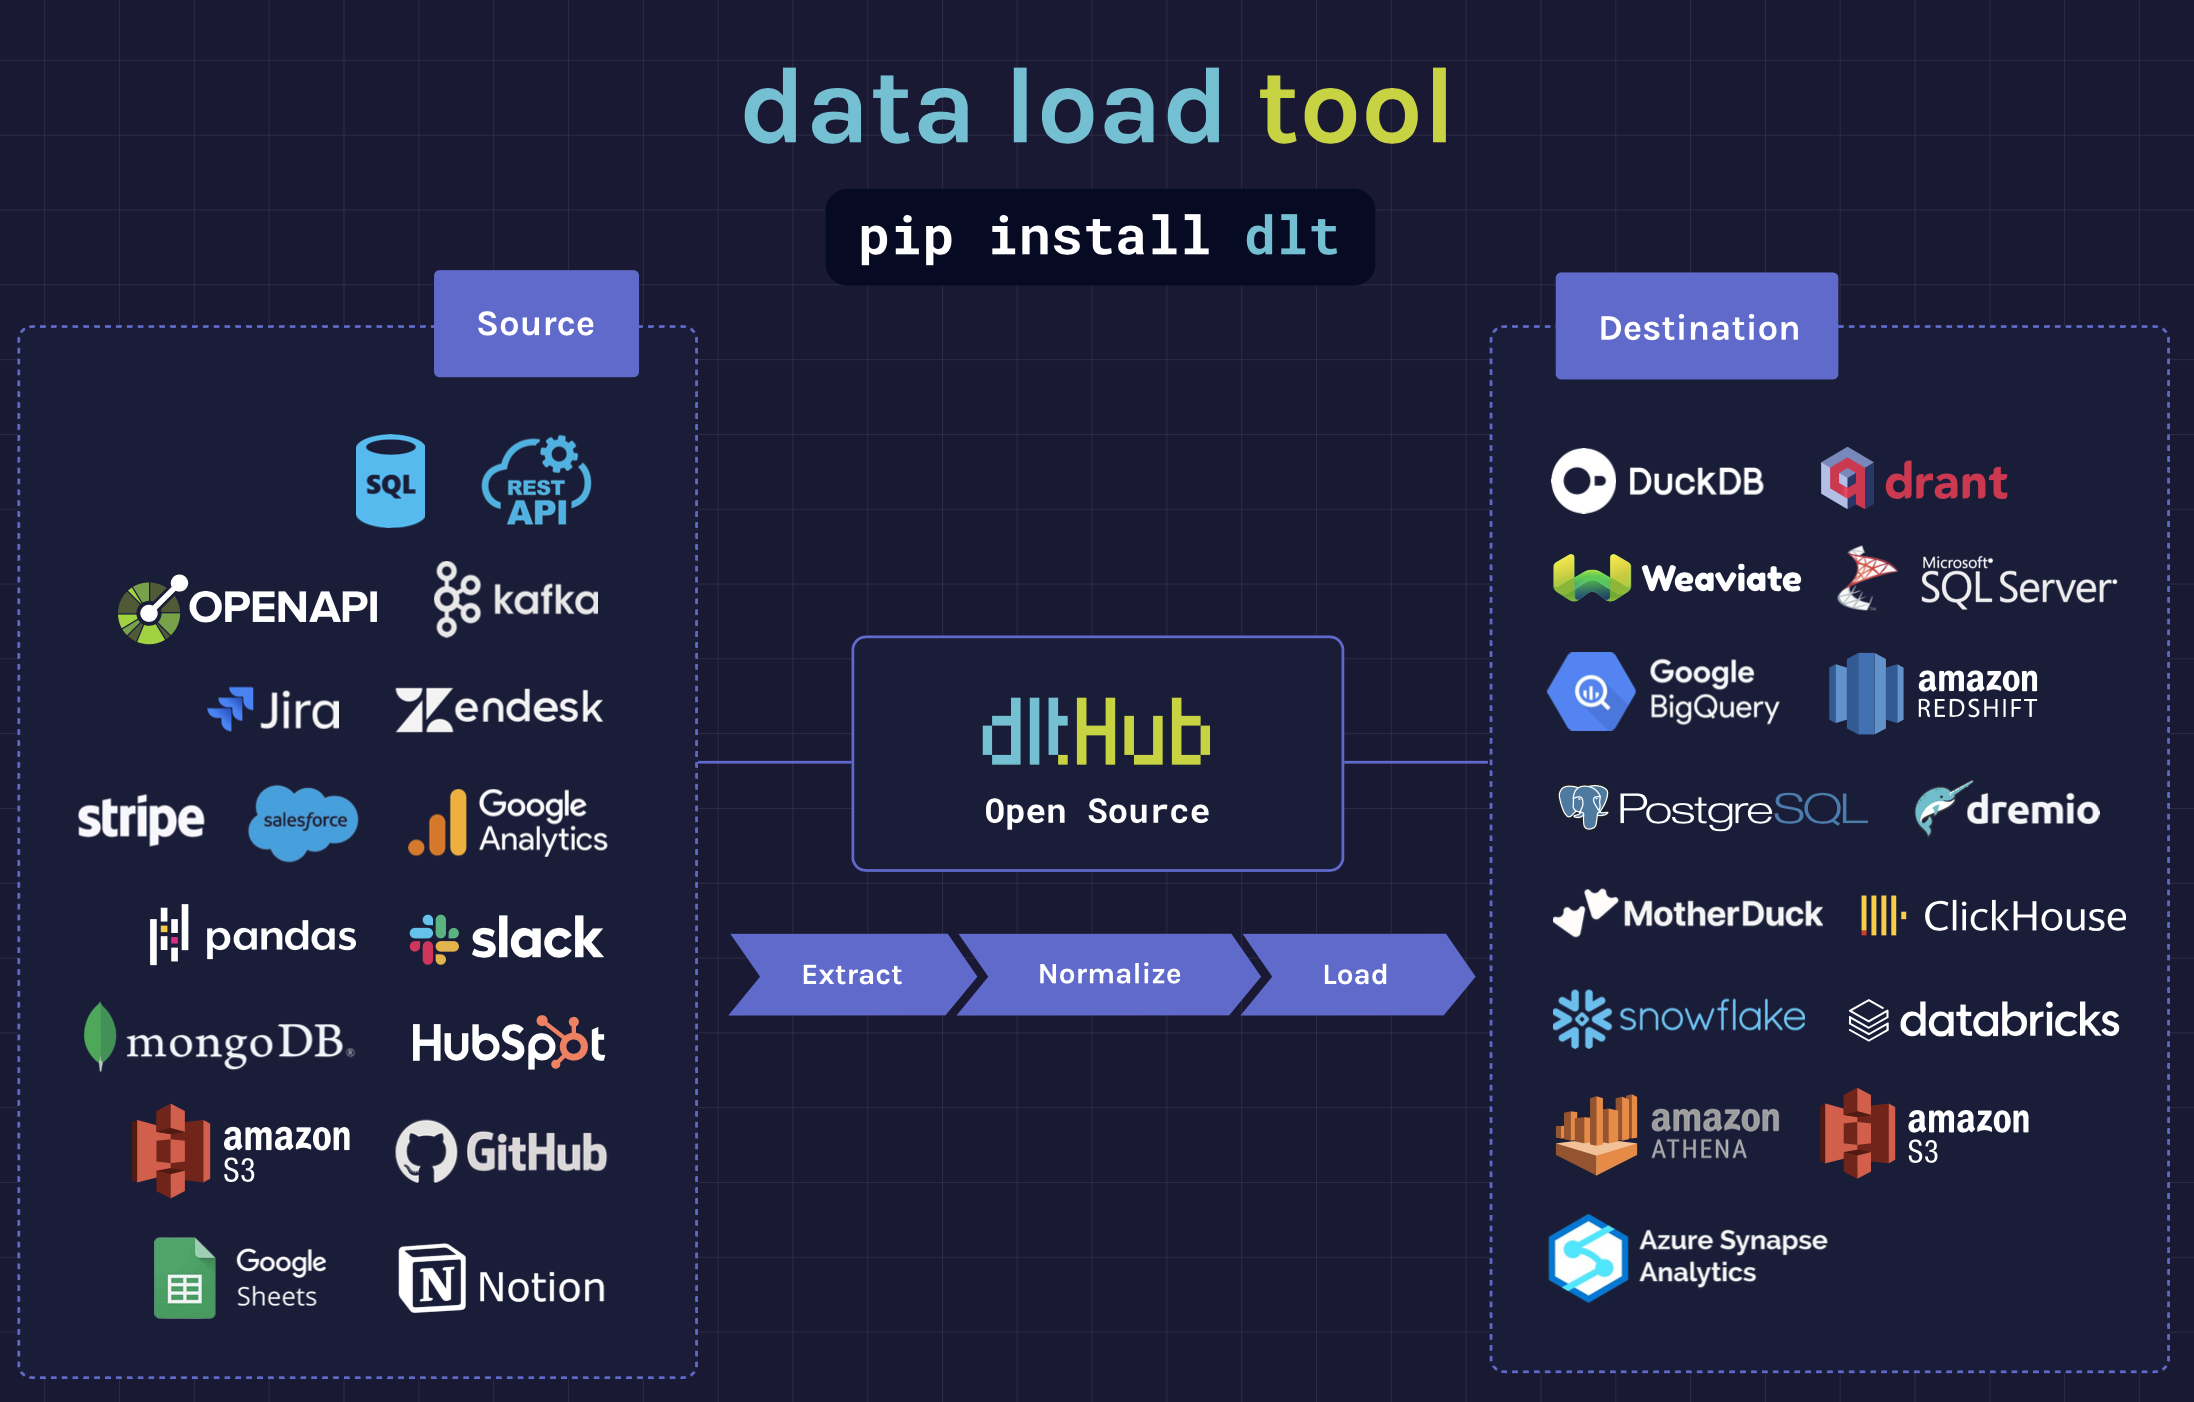

### **Example : Loading data into database with dlt**  



To use all the power of dlt is better to wrap our API Client in the `@dlt.resource` decorator which denotes a logical grouping of data within a data source, typically holding data of similar structure and origin:

In [ ]:
%%capture
!pip install dlt

In [ ]:
import os
import dlt
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator
from google.colab import userdata

os.environ["ACCESS_TOKEN"] = userdata.get('ACCESS_TOKEN')


@dlt.resource(name="events")
def paginated_getter(
    access_token=dlt.secrets.value,
):
    client = RESTClient(
        base_url="https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp/",
        auth=BearerTokenAuth(token=access_token),
        paginator=HeaderLinkPaginator(links_next_key="next"),
    )

    for page in client.paginate("events"):
        yield page



# define new dlt pipeline
pipeline = dlt.pipeline(
    pipeline_name='github_pipeline',
    destination="duckdb",
    dataset_name="events_dataset"
)


# run the pipeline with the new resource
load_info = pipeline.run(paginated_getter, write_disposition="replace") # <--- LOAD ALL DATA
print(pipeline.last_trace)


# explore loaded data
pipeline.dataset(dataset_type="default").events.df()

Pipeline github_pipeline load step completed in 2.56 seconds
1 load package(s) were loaded to destination duckdb and into dataset events_dataset
The duckdb destination used duckdb:////content/github_pipeline.duckdb location to store data
Load package 1740583825.3698518 is LOADED and contains no failed jobs


id              type  actor__id    actor__login  \
0    46956988969         ForkEvent   46575265    kenyanrugger   
1    46956911632        WatchEvent  196861770        Rudra315   
2    46956908155        WatchEvent  196861770        Rudra315   
3    46956408633  PullRequestEvent  150891367           peevk   
4    46956407050  PullRequestEvent  150891367           peevk   
..           ...               ...        ...             ...   
293  46675302267        WatchEvent  106641293  MaryamTALAKOOB   
294  46673279225        WatchEvent   55960716     Wanying-Wei   
295  46673250142        WatchEvent   26360280       chanhoGod   
296  46670266533  PullRequestEvent   23513112         peatwan   
297  46669779936         ForkEvent   23513112         peatwan   

    actor__display_login actor__gravatar_id  \
0           kenyanrugger                      
1               Rudra315                      
2               Rudra315                      
3                  peevk                      
4                  peevk                      
..                   ...                ...   
293       MaryamTALAKOOB                      
294          Wanying-Wei                      
295            chanhoGod                      
296              peatwan                      
297              peatwan                      

                                      actor__url  \
0      https://api.github.com/users/kenyanrugger   
1          https://api.github.com/users/Rudra315   
2          https://api.github.com/users/Rudra315   
3             https://api.github.com/users/peevk   
4             https://api.github.com/users/peevk   
..                                           ...   
293  https://api.github.com/users/MaryamTALAKOOB   
294     https://api.github.com/users/Wanying-Wei   
295       https://api.github.com/users/chanhoGod   
296         https://api.github.com/users/peatwan   
297         https://api.github.com/users/peatwan   

                                     actor__avatar_url   repo__id  \
0    https://avatars.githubusercontent.com/u/46575265?  419661684   
1    https://avatars.githubusercontent.com/u/196861...  419661684   
2    https://avatars.githubusercontent.com/u/196861...  419661684   
3    https://avatars.githubusercontent.com/u/150891...  419661684   
4    https://avatars.githubusercontent.com/u/150891...  419661684   
..                                                 ...        ...   
293  https://avatars.githubusercontent.com/u/106641...  419661684   
294  https://avatars.githubusercontent.com/u/55960716?  419661684   
295  https://avatars.githubusercontent.com/u/26360280?  419661684   
296  https://avatars.githubusercontent.com/u/23513112?  419661684   
297  https://avatars.githubusercontent.com/u/23513112?  419661684   

                                  repo__name  ...  \
0    DataTalksClub/data-engineering-zoomcamp  ...   
1    DataTalksClub/data-engineering-zoomcamp  ...   
2    DataTalksClub/data-engineering-zoomcamp  ...   
3    DataTalksClub/data-engineering-zoomcamp  ...   
4    DataTalksClub/data-engineering-zoomcamp  ...   
..                                       ...  ...   
293  DataTalksClub/data-engineering-zoomcamp  ...   
294  DataTalksClub/data-engineering-zoomcamp  ...   
295  DataTalksClub/data-engineering-zoomcamp  ...   
296  DataTalksClub/data-engineering-zoomcamp  ...   
297  DataTalksClub/data-engineering-zoomcamp  ...   

    payload__pull_request__merged_by__gists_url  \
0                                          None   
1                                          None   
2                                          None   
3                                          None   
4                                          None   
..                                          ...   
293                                        None   
294                                        None   
295                                        None   
296                                        None   
297             

**Done!** All data is now stored in **DuckDB**, with schema managed automatically!  


Note:
* **Replace**: This disposition replaces the data in the destination with the data from the resource. It **deletes** all the data and **recreates** the schema before loading the data.

---

### **Incremental Loading**  

Incremental loading allows us to update datasets by **loading only new or changed data**, instead of replacing the entire dataset. This makes pipelines **faster and more cost-effective** by reducing redundant data processing.  

### **How does incremental loading work?**  

Incremental loading works alongside two key concepts:  

- **Incremental extraction** – Only extracts the new or modified data rather than retrieving everything again.  
- **State tracking** – Keeps track of what has already been loaded, ensuring that only new data is processed.  

In dlt, **state** is stored in a **separate table** at the destination, allowing pipelines to track what has been processed.

🔹 **Want to learn more?** You can read about incremental extraction and state management in the [dlt documentation](https://dlthub.com/docs).  

---

### **Incremental loading methods in dlt**  

dlt provides two ways to load data incrementally:  

#### **1. Append (adding new records)**  

- Best for **immutable or stateless data**, such as GitHub event logs.  
- Each run **adds new records** without modifying previous data.  
- Can also be used to create a **history of changes** (slowly changing dimensions).  

**Example:**  
- If GitHub event data is loaded daily, only **new events** are added, rather than reloading the full history.  
- If tracking changes in repository activity, **each event** is stored as a new row for auditing.  

#### **2. Merge (updating existing records)**  

- Best for **updating existing records** (stateful data).  
- Replaces old records with updated ones based on a **unique key**.  
- Useful for tracking **status changes**, such as issue updates or pull request merges.  

**Example:**  
- A GitHub issue's **status** could change from "open" to "closed," requiring an update.  
- A **user profile** might be updated with a new username or bio.  

---

### **Choosing between Append and Merge**  

| **Scenario**                      | **Use Append** | **Use Merge** |
|-----------------------------------|--------------|--------------|
| Immutable records (e.g., event history) | ✅ Yes         | ❌ No        |
| Tracking historical changes (slowly changing dimensions) | ✅ Yes         | ❌ No        |
| Updating existing records (e.g., issue status) | ❌ No         | ✅ Yes        |
| Keeping full change history       | ✅ Yes         | ❌ No        |




### **Example: Implementing Incremental Loading in dlt**  

To implement incremental loading in dlt, we use state tracking and extraction keys to ensure only new data is processed. Here's an example of loading GitHub events data incrementally:

**The goal**: download only events created after February 25, 2025, skipping older ones.

Using `dlt`, we set up an [incremental filter](https://dlthub.com/docs/general-usage/incremental-loading%23incremental-loading-with-a-cursor-field) to only fetch events created after a certain date:

```python
cursor_date = dlt.sources.incremental("created_at", initial_value="2025-02-25")
```

This tells `dlt`:
- **Start date**: February 25, 2025 (`initial_value`).
- **Field to track**: `created_at` (timestamp of the event).

As you run the pipeline repeatedly, `dlt` will keep track of the latest `created_at` value processed. It will skip records older than this date in future runs.

Let's make the data resource incremental using `dlt.sources.incremental`:



In [ ]:
%%capture
!pip install dlt

In [ ]:
import os
import dlt
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator
from google.colab import userdata

os.environ["ACCESS_TOKEN"] = userdata.get('ACCESS_TOKEN')


@dlt.resource(name="events")
def paginated_getter(
    access_token=dlt.secrets.value,
    cursor_date = dlt.sources.incremental(
        "created_at",     # <--- field to track, our timestamp
        initial_value="2025-02-25"
    )
):
    client = RESTClient(
        base_url="https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp/",
        auth=BearerTokenAuth(token=access_token),
        paginator=HeaderLinkPaginator(links_next_key="next"),
    )

    for page in client.paginate("events"):
        yield page



# define new dlt pipeline
pipeline = dlt.pipeline(
    pipeline_name='github_pipeline',
    destination="duckdb",
    dataset_name="events_dataset"
)


# run the pipeline with the new resource
load_info = pipeline.run(paginated_getter, write_disposition="append") # <--- change 'replace' to 'append'
print(pipeline.last_trace)

Run started at 2025-02-26 15:41:22.583369+00:00 and COMPLETED in 4.43 seconds with 4 steps.
Step extract COMPLETED in 3.17 seconds.

Load package 1740584482.6752703 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.19 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- events: 40 row(s)
- events__payload__pull_request__base__repo__topics: 54 row(s)
- events__payload__commits: 2 row(s)

Load package 1740584482.6752703 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.99 seconds.
Pipeline github_pipeline load step completed in 0.81 seconds
1 load package(s) were loaded to destination duckdb and into dataset events_dataset
The duckdb destination used duckdb:////content/github_pipeline.duckdb location to store data
Load package 1740584482.6752703 is LOADED and contains no failed jobs

Step run COMPLETED in 4.43 seconds.
Pipeline github_pipelin

In [ ]:
! rm -rf /var/dlt/pipelines/

Only 40 rows were flitered out and loaded into the `duckdb` destination. Let's take a look at the earliest date in the loaded data:

In [ ]:
with pipeline.sql_client() as client:
    res = client.execute_sql(
            """
            SELECT
            MIN(created_at)
            FROM events;
            """
        )
    print(res)

[(datetime.datetime(2025, 2, 25, 0, 8, 5, tzinfo=<UTC>),)]


Run the same pipeline again.

In [ ]:
load_info = pipeline.run(paginated_getter, write_disposition="append")
print(pipeline.last_trace)

Run started at 2025-02-26 15:41:44.973799+00:00 and COMPLETED in 4.97 seconds with 4 steps.
Step extract COMPLETED in 4.23 seconds.

Load package 1740584505.9185777 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.37 seconds.
No data found to normalize

Step load COMPLETED in 0.10 seconds.
Pipeline github_pipeline load step completed in ---
0 load package(s) were loaded to destination duckdb and into dataset None
The duckdb destination used duckdb:////content/github_pipeline.duckdb location to store data

Step run COMPLETED in 4.97 seconds.
Pipeline github_pipeline load step completed in ---
0 load package(s) were loaded to destination duckdb and into dataset None
The duckdb destination used duckdb:////content/github_pipeline.duckdb location to store data


The pipeline will detect that there are **no new records** based on the `created_at` field and the incremental cursor. As a result, **no new data will be loaded** into the destination:
>0 load package(s) were loaded

**Updating existing rows with Merge**

If you need to update existing records rather than only appending new ones, you can use the same approach but change `write_disposition` to "merge" and specify a `primary_key`:

In [ ]:
import os
import dlt
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator
from google.colab import userdata

os.environ["ACCESS_TOKEN"] = userdata.get('ACCESS_TOKEN')


@dlt.resource(
    name="events",
    write_disposition="merge", # <--- change write disposition from 'append' to 'merge'
    primary_key="id",  # <--- set unique primary key for merge
)
def paginated_getter(
    access_token=dlt.secrets.value,
    cursor_date = dlt.sources.incremental(
        "created_at",
        initial_value="2025-02-25"
    )
):
    client = RESTClient(
        base_url="https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp/",
        auth=BearerTokenAuth(token=access_token),
        paginator=HeaderLinkPaginator(links_next_key="next"),
    )

    for page in client.paginate("events"):
        yield page



pipeline = dlt.pipeline(
    pipeline_name='github_pipeline_merge', # <--- change the pipeline name because we switch to merge
    destination="duckdb",
    dataset_name="events_dataset"
)


load_info = pipeline.run(paginated_getter) # <--- move write_disposition to the resource decorator
print(pipeline.last_trace)

Run started at 2025-02-26 15:43:23.401984+00:00 and COMPLETED in 7.90 seconds with 4 steps.
Step extract COMPLETED in 3.34 seconds.

Load package 1740584603.4942768 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.60 seconds.
Normalized data for the following tables:
- events: 40 row(s)
- events__payload__pull_request__base__repo__topics: 54 row(s)
- events__payload__commits: 2 row(s)
- _dlt_pipeline_state: 1 row(s)

Load package 1740584603.4942768 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 3.87 seconds.
Pipeline github_pipeline_merge load step completed in 3.44 seconds
1 load package(s) were loaded to destination duckdb and into dataset events_dataset
The duckdb destination used duckdb:////content/github_pipeline_merge.duckdb location to store data
Load package 1740584603.4942768 is LOADED and contains no failed jobs

Step run COMPLETED in 7.90 seconds.
Pipeline gi


This ensures that records with the same id will be updated instead of duplicated, keeping the dataset consistent and avoiding redundant entries.

### **`SCD2` strategy**

In [ ]:
%%capture
!pip install dlt

`dlt` can create Slowly Changing Dimensions Type 2 (SCD2) destination tables for dimension tables that change in the source.

The resource is expected to provide a full extract of the source table each run.

A row hash is stored in `_dlt_id` and used as surrogate key to identify source records that have been inserted, updated, or deleted.

Before running the pipeline, let's just create a small toy dataset representing students at Hogwarts:

In [ ]:
data = [
    {"name": "Vincent Crabbe", "designation": "student", "date_started": "1991-09-01T09:00:00Z"},
    {"name": "Gregory Goyle", "designation": "student", "date_started": "1991-09-01T09:00:00Z"},
    {"name": "Draco Malfoy", "designation": "student", "date_started": "1991-09-01T09:00:00Z"}
]

Now, run the pipeline with merge disposition and SCD2 strategy:

In [ ]:
import dlt

pipeline = dlt.pipeline(
    pipeline_name="hogwarts_pipeline",
    destination="duckdb",
    dataset_name="hogwarts",
)

load_info = pipeline.run(
    data,
    table_name="creatures",
    write_disposition={
        "disposition": "merge", # <--- specifies that existing data should be merged rather than replaced
        "strategy": "scd2" # <--- enables SCD2 tracking, which keeps historical records of changes
    }
)
print(load_info)

_dlt_valid_from _dlt_valid_to            name designation  \
0 2025-03-05 15:48:51.113757+00:00           NaT  Vincent Crabbe     student   
1 2025-03-05 15:48:51.113757+00:00           NaT   Gregory Goyle     student   
2 2025-03-05 15:48:51.113757+00:00           NaT    Draco Malfoy     student   

               date_started       _dlt_load_id         _dlt_id  
0 1991-09-01 09:00:00+00:00  1741189731.113757  P94fUt8jUkzx6A  
1 1991-09-01 09:00:00+00:00  1741189731.113757  Wv4kISjkizZwkQ  
2 1991-09-01 09:00:00+00:00  1741189731.113757  r7u0vNojh+gvEQ

Check what happened:

In [ ]:
pipeline.dataset(dataset_type="default").creatures.df()

_dlt_valid_from _dlt_valid_to            name designation  \
0 2025-03-05 15:48:51.113757+00:00           NaT  Vincent Crabbe     student   
1 2025-03-05 15:48:51.113757+00:00           NaT   Gregory Goyle     student   
2 2025-03-05 15:48:51.113757+00:00           NaT    Draco Malfoy     student   

               date_started       _dlt_load_id         _dlt_id  
0 1991-09-01 09:00:00+00:00  1741189731.113757  P94fUt8jUkzx6A  
1 1991-09-01 09:00:00+00:00  1741189731.113757  Wv4kISjkizZwkQ  
2 1991-09-01 09:00:00+00:00  1741189731.113757  r7u0vNojh+gvEQ

New columns were created:

- `_dlt_valid_from` – The timestamp when this record was first inserted into the table.
  - All records have the same value, which is when the pipeline first processed them.

- `_dlt_valid_to` – The timestamp when this record was considered outdated.
  - NaT (Not a Time) means that these records are currently active and have not been superseded by newer versions.

Modify the dataset by changing Draco Malfoy's designation to "expelled". This simulates a change in source data that should be tracked by SCD2:

In [ ]:
data = [
    {"name": "Vincent Crabbe", "designation": "student", "date_started": "1991-09-01T09:00:00Z"},
    {"name": "Gregory Goyle", "designation": "student", "date_started": "1991-09-01T09:00:00Z"},
    {"name": "Draco Malfoy", "designation": "expelled", "date_started": "1991-09-01T09:00:00Z"}
]

Run the pipeline again with the modified dataset:

In [ ]:
load_info = pipeline.run(
    data,
    table_name="creatures",
    write_disposition={
        "disposition": "merge",
        "strategy": "scd2"
    }
)
print(load_info)

Pipeline hogwarts_pipeline load step completed in 0.26 seconds
1 load package(s) were loaded to destination duckdb and into dataset hogwarts
The duckdb destination used duckdb:////content/hogwarts_pipeline.duckdb location to store data
Load package 1741189902.9085803 is LOADED and contains no failed jobs


Check the database:

In [ ]:
pipeline.dataset(dataset_type="default").creatures.df()

_dlt_valid_from                    _dlt_valid_to  \
0 2025-03-05 15:48:51.113757+00:00                              NaT   
1 2025-03-05 15:48:51.113757+00:00                              NaT   
2 2025-03-05 15:48:51.113757+00:00 2025-03-05 15:51:42.908580+00:00   
3 2025-03-05 15:51:42.908580+00:00                              NaT   

             name designation              date_started        _dlt_load_id  \
0  Vincent Crabbe     student 1991-09-01 09:00:00+00:00   1741189731.113757   
1   Gregory Goyle     student 1991-09-01 09:00:00+00:00   1741189731.113757   
2    Draco Malfoy     student 1991-09-01 09:00:00+00:00   1741189731.113757   
3    Draco Malfoy    expelled 1991-09-01 09:00:00+00:00  1741189902.9085803   

          _dlt_id  
0  P94fUt8jUkzx6A  
1  Wv4kISjkizZwkQ  
2  r7u0vNojh+gvEQ  
3  KCWs+o6jOW/aLQ

SCD2 created a new row for Draco Malfoy with updated designation while keeping the historical record.

**1. Vincent Crabbe & Gregory Goyle (Rows 0 & 1)**
- Their records remain unchanged because their data did **not** change in the second run.
- `_dlt_valid_to = NaT`, meaning their records are still active.
- `_dlt_load_id` remains the same (`1741189731.113757`), indicating they were loaded in the first run.

**2. Draco Malfoy - Previous Record (Row 2)**
- `_dlt_valid_from` → This was his original record when he was a **student**.
- `_dlt_valid_to` → This timestamp marks when this record was **closed** (i.e., it became outdated due to the update).
- `_dlt_id` → This is the original hash, uniquely identifying the record.
- **This row is now a historical record, no longer active.**

**3. Draco Malfoy - New Record (Row 3)**
- `_dlt_valid_from` → Marks when this new version of the record was inserted.
- `_dlt_valid_to = NaT` → This means it is the **current active record**.
- `designation = "expelled"` → The change is now reflected.
- `_dlt_load_id` → This is from the second pipeline run, tracking when this new row was inserted.
- `_dlt_id` → A new hash is generated because the record has changed.


💡 **With dlt, incremental loading is simple, scalable, and automatic!**


### **Choosing a destination**

Switching between  **data warehouses (BigQuery, Snowflake, Redshift)** or **data lakes (S3, Google Cloud Storage, Parquet files)**  in dlt is incredibly straightforward — simply modify the `destination` parameter in your pipeline configuration.

For example:

In [ ]:
pipeline = dlt.pipeline(
    pipeline_name='github_pipeline',
    destination='duckdb', # <--- to test pipeline locally
    dataset_name='events_dataset',
)

pipeline = dlt.pipeline(
    pipeline_name='github_pipeline',
    destination='bigquery', # <--- to run pipeline in production
    dataset_name='events_dataset',
)

2025-02-10 16:45:11,951|[WARNING]|1260|135258517532672|dlt|pipeline.py|_state_to_props:1644|The destination dlt.destinations.duckdb:duckdb in state differs from destination dlt.destinations.bigquery:bigquery in pipeline and will be ignored


This flexibility allows you to easily transition from local development to production-grade environments.

> 💡 No need to rewrite your pipeline — dlt adapts automatically!

### **Example: Loading data into a Data Warehouse (BigQuery)**  
First, install the dependencies, define the source, then change the destination name and run the pipeline.

In [ ]:
%%capture
!pip install dlt[bigquery]

Let's use our GitHub API and load data from the source into destination.

In [ ]:
import os
import dlt
from dlt.sources.helpers.rest_client import RESTClient
from dlt.sources.helpers.rest_client.auth import BearerTokenAuth
from dlt.sources.helpers.rest_client.paginators import HeaderLinkPaginator
from google.colab import userdata

os.environ["ACCESS_TOKEN"] = userdata.get('ACCESS_TOKEN')


@dlt.resource(
    name="events",
    write_disposition="merge",
    primary_key="id",
)
def paginated_getter(
    access_token=dlt.secrets.value,
    cursor_date = dlt.sources.incremental(
        "created_at",
        initial_value="2025-02-25"
    )
):
    client = RESTClient(
        base_url="https://api.github.com/repos/DataTalksClub/data-engineering-zoomcamp/",
        auth=BearerTokenAuth(token=access_token),
        paginator=HeaderLinkPaginator(links_next_key="next"),
    )

    for page in client.paginate("events"):
        yield page




**Set Credentials**  

The next logical step is to [set credentials](https://dlthub.com/docs/general-usage/credentials/) using **dlt's TOML providers** or **environment variables (ENVs)**.



In [ ]:
import os
from google.colab import userdata

os.environ["DESTINATION__BIGQUERY__CREDENTIALS"] = userdata.get('BIGQUERY_CREDENTIALS')

Change the destination and run the pipeline:

In [ ]:
pipeline = dlt.pipeline(
    pipeline_name='github_pipeline_merge',
    destination="bigquery", # <--- new destination
    dataset_name="events_dataset",
)


load_info = pipeline.run(paginated_getter)
print(pipeline.last_trace)

2025-02-26 15:56:27,122|[WARNING]|23007|140047007621120|dlt|pipeline.py|_state_to_props:1642|The destination dlt.destinations.duckdb:None in state differs from destination dlt.destinations.bigquery:bigquery in pipeline and will be ignored


Run started at 2025-02-26 15:56:27.284184+00:00 and COMPLETED in 51.79 seconds with 4 steps.
Step extract COMPLETED in 3.15 seconds.

Load package 1740585390.8586187 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.19 seconds.
Normalized data for the following tables:
- events: 40 row(s)
- events__payload__pull_request__base__repo__topics: 54 row(s)
- events__payload__commits: 2 row(s)
- _dlt_pipeline_state: 1 row(s)

Load package 1740585390.8586187 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 44.88 seconds.
Pipeline github_pipeline_merge load step completed in 44.70 seconds
1 load package(s) were loaded to destination bigquery and into dataset events_dataset
The bigquery destination used sandbox-main@dlthub-sandbox.iam.gserviceaccount.com@dlthub-sandbox location to store data
Load package 1740585390.8586187 is LOADED and contains no failed jobs

Step run COMPLETED in

Look at the data: https://console.cloud.google.com/bigquery?hl=en&inv=1&invt=AbqnXQ&project=dlthub-sandbox&ws=!1m0


💡 **What’s different?**  
- **dlt automatically adapts the schema** to fit BigQuery.  
- **Partitioning & clustering** can be applied for performance optimization.  
- **Efficient batch loading** ensures scalability.  


---

## **Data Lakes: Scalable storage for Big Data**

> "Store everything, access anything."

**What is a Data Lake?**

We’ve heard of datasets and databases, what is a data lake?

A data lake is a centralized repository to store all your raw data. It allows you to store vast amounts of raw data in its native format, including structured, semi-structured, and unstructured data.

Unlike traditional databases or data warehouses, data lakes are designed to handle diverse data types and formats at any scale, enabling advanced analytics, machine learning, and data exploration.





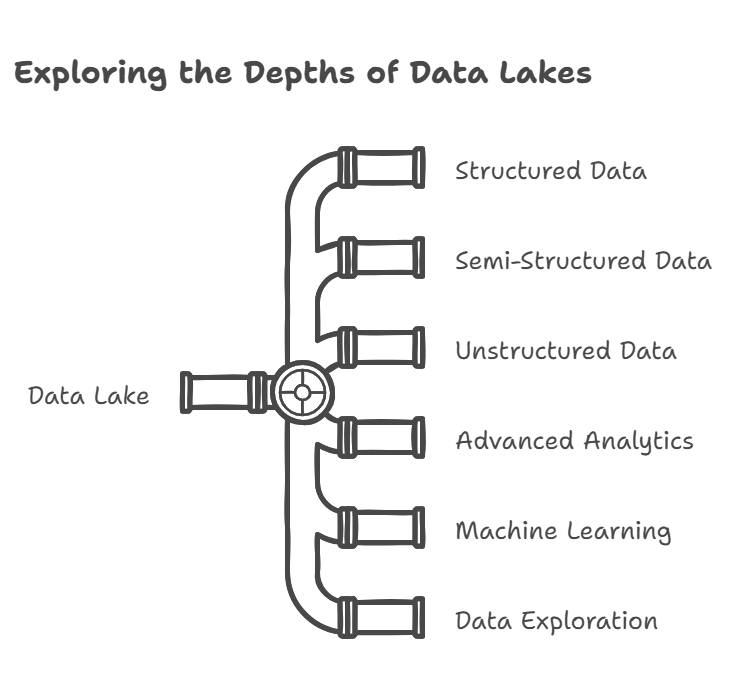

💡 **Why use a Data Lake?**  
- **Scalability** - Can store vast amounts of data without upfront structuring.
- **Flexibility** - Supports multiple formats (CSV, JSON, Parquet, Avro, ORC).
- **Cost-efficiency** - Uses low-cost cloud storage (e.g., Amazon S3, Google Cloud Storage, Azure Blob Storage).
- **Schema-on-Read** - Data is structured only when queried, making it adaptable for multiple use cases.


### **Data Lakes vs. Data Warehouses**
| Feature           | Data Lake | Data Warehouse |
|------------------|-----------|---------------|
| Storage Format  | Raw, unstructured, structured | Structured, optimized |
| Processing     | Schema-on-read | Schema-on-write |
| Cost           | Lower (cheap storage, pay-as-you-go processing) | Higher (optimized compute and storage) |
| Use Cases      | Data science, machine learning, flexible analytics | BI reporting, structured queries |


### **When to use a Data Lake**
Data lakes are ideal for:
- **Ingesting raw data from multiple sources** (APIs, logs, databases, IoT devices).
- **Machine learning and advanced analytics**, where historical data is needed for model training.
- **Event-driven architectures** that rely on real-time streaming data.
- **Multi-format data processing** (e.g., combining JSON logs, Parquet transaction data, and image files).



### **Example: Loading data into a Data Lake with dlt (Parquet on Local FS)**  

The `filesystem` destination enables you to load data into **files stored locally** or in **cloud storage** solutions, making it an excellent choice for lightweight testing, prototyping, or file-based workflows.

Below is an **example** demonstrating how to use the `filesystem` destination to load data in **Parquet** format:

* Step 1: Set up a local bucket or cloud directory for storing files

In [ ]:
import os

os.environ["BUCKET_URL"] = "/content"

* Step 2: Define the data source (above)
* Step 3:Change the destination
* Step 4: Run the pipeline

In [ ]:
import dlt


pipeline = dlt.pipeline(
    pipeline_name='fs_pipeline',
    destination='filesystem', # <--- change destination to 'filesystem'
    dataset_name='fs_data',
)

load_info = pipeline.run(
    paginated_getter,
    loader_file_format="parquet", # <--- choose a file format: parquet, csv or jsonl
    write_disposition="append" # <--- filesystem destinaition doesn't support merge will fall back to `append`
)
print(pipeline.last_trace)

Run started at 2025-02-27 10:51:20.075831+00:00 and COMPLETED in 3.99 seconds with 4 steps.
Step extract COMPLETED in 3.10 seconds.

Load package 1740653480.2048748 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.37 seconds.
Normalized data for the following tables:
- events: 76 row(s)
- events__payload__pull_request__base__repo__topics: 66 row(s)
- events__payload__commits: 2 row(s)
- _dlt_pipeline_state: 1 row(s)

Load package 1740653480.2048748 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 0.40 seconds.
Pipeline fs_pipeline load step completed in 0.16 seconds
1 load package(s) were loaded to destination filesystem and into dataset fs_data
The filesystem destination used file:///content location to store data
Load package 1740653480.2048748 is LOADED and contains no failed jobs

Step run COMPLETED in 3.99 seconds.
Pipeline fs_pipeline load step completed in 0.16 sec

Look at the files:

In [ ]:
! ls fs_data/events

1740653480.2048748.7c4532e84c.parquet


Look at the loaded data:

In [ ]:
# explore loaded data
pipeline.dataset(dataset_type="default").events.df()

id        type  actor__id        actor__login  \
0   46993297916  WatchEvent    7319375               tiaho   
1   46992275226   ForkEvent  100037252         Marinazuzum   
2   46991707431  WatchEvent   59856314            JTanner4   
3   46991551023  WatchEvent  136226032            Nurikona   
4   46991361470   ForkEvent  106300889        shijohimself   
..          ...         ...        ...                 ...   
71  46914884387  WatchEvent   54641143  PrathibaSwamykannu   
72  46914091950  WatchEvent   55864839         MaxineXiong   
73  46913885640  WatchEvent   80333460             safakan   
74  46912994298  WatchEvent   98726831          ronaldtieu   
75  46912642047  WatchEvent  150637830            hajarshu   

   actor__display_login actor__gravatar_id  \
0                 tiaho                      
1           Marinazuzum                      
2              JTanner4                      
3              Nurikona                      
4          shijohimself                      
..                  ...                ...   
71   PrathibaSwamykannu                      
72          MaxineXiong                      
73              safakan                      
74           ronaldtieu                      
75             hajarshu                      

                                         actor__url  \
0                https://api.github.com/users/tiaho   
1          https://api.github.com/users/Marinazuzum   
2             https://api.github.com/users/JTanner4   
3             https://api.github.com/users/Nurikona   
4         https://api.github.com/users/shijohimself   
..                                              ...   
71  https://api.github.com/users/PrathibaSwamykannu   
72         https://api.github.com/users/MaxineXiong   
73             https://api.github.com/users/safakan   
74          https://api.github.com/users/ronaldtieu   
75            https://api.github.com/users/hajarshu   

                                    actor__avatar_url   repo__id  \
0    https://avatars.githubusercontent.com/u/7319375?  419661684   
1   https://avatars.githubusercontent.com/u/100037...  419661684   
2   https://avatars.githubusercontent.com/u/59856314?  419661684   
3   https://avatars.githubusercontent.com/u/136226...  419661684   
4   https://avatars.githubusercontent.com/u/106300...  419661684   
..                                                ...        ...   
71  https://avatars.githubusercontent.com/u/54641143?  419661684   
72  https://avatars.githubusercontent.com/u/55864839?  419661684   
73  https://avatars.githubusercontent.com/u/80333460?  419661684   
74  https://avatars.githubusercontent.com/u/98726831?  419661684   
75  https://avatars.githubusercontent.com/u/150637...  419661684   

                                 repo__name  ...  \
0   DataTalksClub/data-engineering-zoomcamp  ...   
1   DataTalksClub/data-engineering-zoomcamp  ...   
2   DataTalksClub/data-engineering-zoomcamp  ...   
3   DataTalksClub/data-engineering-zoomcamp  ...   
4   DataTalksClub/data-engineering-zoomcamp  ...   
..                                      ...  ...   
71  DataTalksClub/data-engineering-zoomcamp  ...   
72  DataTalksClub/data-engineering-zoomcamp  ...   
73  DataTalksClub/data-engineering-zoomcamp  ...   
74  DataTalksClub/data-engineering-zoomcamp  ...   
75  DataTalksClub/data-engineering-zoomcamp  ...   

   payload__pull_request__deletions payload__pull_request__changed_files  \
0                               NaN                                  NaN   
1                               NaN                                  NaN   
2                               NaN                                  NaN   
3                               NaN                                  NaN   
4                               NaN                                  NaN   
..                              ...                                  ...   
71                              NaN                                  NaN   
72  

#### **Table formats: [Delta tables & Iceberg](https://dlthub.com/docs/dlt-ecosystem/destinations/delta-iceberg)**

dlt supports writing **Delta** and **Iceberg** tables when using the `filesystem` destination.

**How it works:**

dlt uses the `deltalake` and `pyiceberg` libraries to write Delta and Iceberg tables, respectively. One or multiple Parquet files are prepared during the extract and normalize steps. In the load step, these Parquet files are exposed as an Arrow data structure and fed into `deltalake` or `pyiceberg`.

In [ ]:
%%capture
!pip install "dlt[pyiceberg]"

In [ ]:
pipeline = dlt.pipeline(
    pipeline_name='fs_iceberg_pipeline',
    destination='filesystem',
    dataset_name='fs_iceberg_data',
)

load_info = pipeline.run(
    paginated_getter,
    loader_file_format="parquet",
    write_disposition="append",
    table_format="iceberg",  # <--- choose a table format: delta or iceberg
)
print(pipeline.last_trace)

Run started at 2025-02-26 16:34:43.422721+00:00 and COMPLETED in 7.11 seconds with 4 steps.
Step extract COMPLETED in 3.79 seconds.

Load package 1740587683.477246 is EXTRACTED and NOT YET LOADED to the destination and contains no failed jobs

Step normalize COMPLETED in 0.36 seconds.
Normalized data for the following tables:
- _dlt_pipeline_state: 1 row(s)
- events: 41 row(s)
- events__payload__pull_request__base__repo__topics: 54 row(s)
- events__payload__commits: 2 row(s)

Load package 1740587683.477246 is NORMALIZED and NOT YET LOADED to the destination and contains no failed jobs

Step load COMPLETED in 2.92 seconds.
Pipeline fs_iceberg_pipeline load step completed in 2.61 seconds
1 load package(s) were loaded to destination filesystem and into dataset fs_iceberg_data
The filesystem destination used file:///content location to store data
Load package 1740587683.477246 is LOADED and contains no failed jobs

Step run COMPLETED in 7.11 seconds.
Pipeline fs_iceberg_pipeline load step 

💡**Note:**

Open source version of dlt supports basic functionality for **iceberg**, but the dltHub team is currently working on an **extended** and **more powerful** integration with iceberg.

[Join the waiting list to learn more about dlt+ and Iceberg.](https://info.dlthub.com/waiting-list)

### **Example: Loading data into a Data Lake with dlt (Parquet on AWS S3)**  

**Switching from Local to S3 Storage**

To transition from local storage to S3, you need to:

- Create a bucket
- Configure AWS credentials.
- Set the S3 bucket URL.
- Modify the destination settings in your pipeline.

In [ ]:
%%capture
!pip install "dlt[s3]"

**Step 1: Configure AWS Credentials**

Ensure your AWS credentials are set up. You can authenticate in multiple ways, in this example we consider setting ENVs:

In [ ]:
import os
from google.colab import userdata
import dlt

# another way to set your credentials for dlt pipelines, you can use ENVs as well
dlt.secrets["destination.filesystem.credentials.aws_access_key_id"] = userdata.get('AWS_ACCESS_KEY_ID')
dlt.secrets["destination.filesystem.credentials.aws_secret_access_key"] = userdata.get('AWS_SECRET_ACCESS_KEY')
dlt.secrets["destination.filesystem.credentials.region_name"]= "eu-central-1"

**Step 2: Set the S3 Bucket URL**

In [ ]:
import os

dlt.secrets["destination.filesystem.bucket_url"]= "s3://gtm-demos/freecodecamp-demo/"

* Step 2: Define the data source (above)
* Step 3:Change the destination
* Step 4: Run the pipeline

In [ ]:
import dlt


pipeline = dlt.pipeline(
    pipeline_name='fs_s3_iceberg_pipeline',
    destination='filesystem', # <--- change destination to 'filesystem'
    dataset_name='fs_s3_iceberg_data',
)

load_info = pipeline.run(
    paginated_getter,
    loader_file_format="parquet", # <--- choose a file format: parquet, csv or jsonl
    write_disposition="append", # <--- filesystem destinaition doesn't support merge will fall back to `append`
    # table_format="iceberg",
)
print(pipeline.last_trace)

2025-02-27 11:15:33,854|[WARNING]|312|138127337447424|dlt|pipeline.py|run:723|The pipeline `run` method will now load the pending load packages. The data you passed to the run function will not be loaded. In order to do that you must run the pipeline again


Run started at 2025-02-27 11:15:32.065487+00:00 and COMPLETED in 20.30 seconds with 2 steps.
Step load COMPLETED in 18.51 seconds.
Pipeline fs_s3_iceberg_pipeline load step completed in 18.06 seconds
1 load package(s) were loaded to destination filesystem and into dataset fs_s3_iceberg_data
The filesystem destination used s3://gtm-demos/freecodecamp-demo/ location to store data
Load package 1740654895.5241275 is LOADED and contains no failed jobs

Step run COMPLETED in 20.30 seconds.
Pipeline fs_s3_iceberg_pipeline load step completed in 18.06 seconds
1 load package(s) were loaded to destination filesystem and into dataset fs_s3_iceberg_data
The filesystem destination used s3://gtm-demos/freecodecamp-demo/ location to store data
Load package 1740654895.5241275 is LOADED and contains no failed jobs


In [ ]:
pipeline.dataset(dataset_type="default").events.df().head()

id        type  actor__id     actor__login actor__display_login  \
0  46995242564   ForkEvent  196608084  Ganeshbabu-tech      Ganeshbabu-tech   
1  46993297916  WatchEvent    7319375            tiaho                tiaho   
2  46992275226   ForkEvent  100037252      Marinazuzum          Marinazuzum   
3  46991707431  WatchEvent   59856314         JTanner4             JTanner4   
4  46991551023  WatchEvent  136226032         Nurikona             Nurikona   

  actor__gravatar_id                                    actor__url  \
0                     https://api.github.com/users/Ganeshbabu-tech   
1                               https://api.github.com/users/tiaho   
2                         https://api.github.com/users/Marinazuzum   
3                            https://api.github.com/users/JTanner4   
4                            https://api.github.com/users/Nurikona   

                                   actor__avatar_url   repo__id  \
0  https://avatars.githubusercontent.com/u/196608...  419661684   
1   https://avatars.githubusercontent.com/u/7319375?  419661684   
2  https://avatars.githubusercontent.com/u/100037...  419661684   
3  https://avatars.githubusercontent.com/u/59856314?  419661684   
4  https://avatars.githubusercontent.com/u/136226...  419661684   

                                repo__name  ...  \
0  DataTalksClub/data-engineering-zoomcamp  ...   
1  DataTalksClub/data-engineering-zoomcamp  ...   
2  DataTalksClub/data-engineering-zoomcamp  ...   
3  DataTalksClub/data-engineering-zoomcamp  ...   
4  DataTalksClub/data-engineering-zoomcamp  ...   

  payload__pull_request__deletions  payload__pull_request__changed_files  \
0                              NaN                                   NaN   
1                              NaN                                   NaN   
2                              NaN                                   NaN   
3                              NaN                                   NaN   
4                              NaN                                   NaN   

  payload__pull_request__body payload__repository_id payload__push_id  \
0                        None                    NaN              NaN   
1                        None                    NaN              NaN   
2                        None                    NaN              NaN   
3                        None                    NaN              NaN   
4                        None                    NaN              NaN   

  payload__size payload__distinct_size  payload__ref payload__head  \
0           NaN                    NaN          None          None   
1           NaN                    NaN          None          None   
2           NaN                    NaN          None          None   
3           NaN                    NaN          None          None   
4           NaN                    NaN          None          None   

  payload__before  
0            None  
1            None  
2            None  
3            None  
4            None  

[5 rows x 416 columns]

**Look at this magic:**  

With just **one line of code**, you can instantly access your Parquet data from S3 as a **pandas DataFrame**:  

```python
pipeline.dataset(dataset_type="default").events.df().head()
```

✨ **No manual file handling.**  
✨ **No S3 download needed.**  
✨ **Your data, ready to explore in seconds.**  

Let me break it down:  
1️⃣ **`pipeline.dataset(dataset_type="default")`** → Connects to your dataset stored in S3.  
2️⃣ **`.events.df()`** → Reads it into a pandas DataFrame.  
3️⃣ **`.head()`** → Displays the first few rows.  

And just like that, you’re analyzing your **Parquet-stored** data instantly! 😎🔥  

Let me explain how this works behind the scenes… 🚀

### **Data access**

The pipeline variable declared so far has an additional cool functionality: [datasets](https://dlthub.com/docs/general-usage/dataset-access/dataset)!

Usually, when you load your data to a certain destination, you would only be able to access it through the interface provided by that particular destination. For example, BigQuery interface from Google or BigQuery Python client on Python. Basically - you’d be looking for the connectors and other forms of glue code to be able to explore data in a destination, after the EL process.

In dlt, you can extract a `dataset` object as simply as:

```python
dataset = pipeline.dataset()
```

Some basic functionality for this dataset is to look at row counts of all tables or entities in the dataset:

In [ ]:
dataset = pipeline.dataset(dataset_type="default")
print(dataset.row_counts().df())

                                          table_name  row_count
0                                             events         77
1  events__payload__pull_request__base__repo__topics         66
2                           events__payload__commits          2


Let’s say we’d like a sneak peak into the `events__payload__commits` entity. The way to do that with `dataset` is:


In [ ]:
# convert to dataframe:
df = dataset['events__payload__commits'].df()
df

sha       author__email  author__name  \
0  382a27746abe7fba88121cb21c41cea5585d91a2  wrussell@kestra.io  Will Russell   
1  776d991a64c753c1c3bc7b85c3ebfecb3e9bc668  wrussell@kestra.io  Will Russell   

                      message  distinct  \
0  fix: add a working version      True   
1    fix: match video version      True   

                                                 url  _dlt_parent_id  \
0  https://api.github.com/repos/DataTalksClub/dat...  djfA/gRVzAYjxQ   
1  https://api.github.com/repos/DataTalksClub/dat...  oWj+CNJmPVrsjw   

   _dlt_list_idx         _dlt_id  
0              0  ALtquUY6ojOgzQ  
1              0  F/JQ58HmsbALmQ

If you have a larger table, you can load it with limitations:

In [ ]:
dataset['events'].limit(10).df()


id        type  actor__id     actor__login actor__display_login  \
0  46995242564   ForkEvent  196608084  Ganeshbabu-tech      Ganeshbabu-tech   
1  46993297916  WatchEvent    7319375            tiaho                tiaho   
2  46992275226   ForkEvent  100037252      Marinazuzum          Marinazuzum   
3  46991707431  WatchEvent   59856314         JTanner4             JTanner4   
4  46991551023  WatchEvent  136226032         Nurikona             Nurikona   
5  46991361470   ForkEvent  106300889     shijohimself         shijohimself   
6  46990553451  WatchEvent   35702392     julian-brito         julian-brito   
7  46990434326  WatchEvent    7060432         sylverek             sylverek   
8  46989861302  WatchEvent  144892516         rayluo88             rayluo88   
9  46988652388   ForkEvent  200329714  iwan-goodfellow      iwan-goodfellow   

  actor__gravatar_id                                    actor__url  \
0                     https://api.github.com/users/Ganeshbabu-tech   
1                               https://api.github.com/users/tiaho   
2                         https://api.github.com/users/Marinazuzum   
3                            https://api.github.com/users/JTanner4   
4                            https://api.github.com/users/Nurikona   
5                        https://api.github.com/users/shijohimself   
6                        https://api.github.com/users/julian-brito   
7                            https://api.github.com/users/sylverek   
8                            https://api.github.com/users/rayluo88   
9                     https://api.github.com/users/iwan-goodfellow   

                                   actor__avatar_url   repo__id  \
0  https://avatars.githubusercontent.com/u/196608...  419661684   
1   https://avatars.githubusercontent.com/u/7319375?  419661684   
2  https://avatars.githubusercontent.com/u/100037...  419661684   
3  https://avatars.githubusercontent.com/u/59856314?  419661684   
4  https://avatars.githubusercontent.com/u/136226...  419661684   
5  https://avatars.githubusercontent.com/u/106300...  419661684   
6  https://avatars.githubusercontent.com/u/35702392?  419661684   
7   https://avatars.githubusercontent.com/u/7060432?  419661684   
8  https://avatars.githubusercontent.com/u/144892...  419661684   
9  https://avatars.githubusercontent.com/u/200329...  419661684   

                                repo__name  ...  \
0  DataTalksClub/data-engineering-zoomcamp  ...   
1  DataTalksClub/data-engineering-zoomcamp  ...   
2  DataTalksClub/data-engineering-zoomcamp  ...   
3  DataTalksClub/data-engineering-zoomcamp  ...   
4  DataTalksClub/data-engineering-zoomcamp  ...   
5  DataTalksClub/data-engineering-zoomcamp  ...   
6  DataTalksClub/data-engineering-zoomcamp  ...   
7  DataTalksClub/data-engineering-zoomcamp  ...   
8  DataTalksClub/data-engineering-zoomcamp  ...   
9  DataTalksClub/data-engineering-zoomcamp  ...   

  payload__pull_request__deletions  payload__pull_request__changed_files  \
0                              NaN                                   NaN   
1                              NaN                                   NaN   
2                              NaN                                   NaN   
3                              NaN                                   NaN   
4                              NaN                                   NaN   
5                              NaN                                   NaN   
6                              NaN                                   NaN   
7                              NaN                                   NaN   
8                              NaN                                   NaN   
9                              NaN                                   NaN   

  payload__pull_request__body payload__repository_id payload__push_id  \
0                        None                    NaN              NaN   
1                        None                    NaN              NaN   
2              

OR select particular columns


In [ ]:
dataset['events'].select("id", "type").df()

id        type
0   46995242564   ForkEvent
1   46993297916  WatchEvent
2   46992275226   ForkEvent
3   46991707431  WatchEvent
4   46991551023  WatchEvent
..          ...         ...
72  46914884387  WatchEvent
73  46914091950  WatchEvent
74  46913885640  WatchEvent
75  46912994298  WatchEvent
76  46912642047  WatchEvent

[77 rows x 2 columns]

That’s how easily you can access your datasets to inspect what has been loaded!

#### **Loading mechanism**

The loading mechanism for this ensures that no extra steps are taken when you refer to the datasets. This means that they do not immediately fetch data when you initialize a dataset. Data is only retrieved when you perform an action that requires it, such as calling `.df()`, `.arrow()`, or iterating over the data. This approach optimizes performance and reduces unnecessary data loading, and is called lazy loading!

**Coming back to the idea of data lakes**: You can apply transformations on top of this data, make data models in dbt, deploy, and orchestrate them.

## **Move Data from SQL Database to SQL Database**

> Let `dlt` do the heavy lifting for you.
>

Transferring data between SQL databases is a common task in data engineering, whether for migrations, ETL processes, or synchronizing databases. dlt simplifies this process by providing verified sources that support a wide range of SQL databases through SQLAlchemy dialects.

Let's explore how simple data migration can be with dlt. In this section, we'll demonstrate pulling data from a **SQL database** as the source and transferring it to **DuckDB**. This setup offers numerous possibilities—for instance, you can treat your **SQL database** as the primary data source, use **DuckDB** as an intermediary staging layer for exploration and transformations, and finally, load the processed data into **PostgreSQL** for long-term storage and analytics.

Here, we’ll just do the first half and the latter will be self explanatory :)   

**Steps:**

1. Initialize a `dlt` project in the current working directory by running the following command:
    
    ```bash
    dlt init sql_database duckdb
    ```
    
    This will add necessary files and configurations for a `dlt` pipeline with SQL database as the source and [DuckDB](https://dlthub.com/docs/dlt-ecosystem/destinations/duckdb) as the destination.

    **Note**: The `sql_database` source is also a **built-in source**, you don't have to initialize it, just **import** it from `dlt.sources`.
    

### **Example: Loading data from MySQL database into DuckDB**

The example below will show you how you can use dlt to load data from a SQL Database (PostgreSQL, MySQL, SQLight, Oracle, IBM DB2, etc.) into destination.

To make it easy to reproduce, we will be loading data from the [public MySQL RFam database](https://docs.rfam.org/en/latest/database.html) into a local DuckDB instance.

In [ ]:
%%capture
!pip install dlt pymysql

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.4/892.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.9/384.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 8.5 MB/s eta 0:00:00


In [ ]:
import dlt
from dlt.sources.sql_database import sql_database

source = sql_database(
    "mysql+pymysql://rfamro@mysql-rfam-public.ebi.ac.uk:4497/Rfam",
    table_names=["family",],
    backend="pyarrow"
)

pipeline = dlt.pipeline(
    pipeline_name="sql_database_example",
    destination="duckdb",
    dataset_name="sql_data",
    dev_mode=True,
)

load_info = pipeline.run(source)
print(load_info)

Pipeline sql_database_example load step completed in 1.56 seconds
1 load package(s) were loaded to destination duckdb and into dataset sql_data_20250305115104
The duckdb destination used duckdb:////content/sql_database_example.duckdb location to store data
Load package 1741175464.933475 is LOADED and contains no failed jobs


In [ ]:
# explore loaded data
pipeline.dataset(dataset_type="default").family.df()

rfam_acc            rfam_id  auto_wiki  \
0     RF00001            5S_rRNA       1302   
1     RF00002          5_8S_rRNA       1303   
2     RF00003                 U1       1304   
3     RF00004                 U2       1305   
4     RF00005               tRNA       1306   
...       ...                ...        ...   
4173  RF04306         HCV_SL8001       2418   
4174  RF04307         HCV_SL8670       2418   
4175  RF04308  HCV_SL2531-SL2549       2418   
4176  RF04309          HCV_J7880       2418   
4177  RF04310            nqrA-II       2768   

                                          description  \
0                                    5S ribosomal RNA   
1                                  5.8S ribosomal RNA   
2                                 U1 spliceosomal RNA   
3                                 U2 spliceosomal RNA   
4                                                tRNA   
...                                               ...   
4173           Hepatitis C virus stem-loop SL8001 RNA   
4174               Hepatitis C virus stem-loop SL8670   
4175  Hepatitis C virus stem-loop SL2531 and SL2549AU   
4176                      Hepatitis C virus J7880 RNA   
4177                              nqrA-II ncRNA motif   

                                                 author  \
0              Griffiths-Jones SR, Mifsud W, Gardner PP   
1                          Griffiths-Jones SR, Mifsud W   
2     Griffiths-Jones SR, Mifsud W, Moxon SJ, Ontive...   
3              Griffiths-Jones SR, Mifsud W, Gardner PP   
4                 Eddy SR, Griffiths-Jones SR, Mifsud W   
...                                                 ...   
4173                    Lamkiewicz K, Triebel S, Marz M   
4174                    Lamkiewicz K, Triebel S, Marz M   
4175                    Lamkiewicz K, Triebel S, Marz M   
4176                    Lamkiewicz K, Triebel S, Marz M   
4177       Narunsky A, Breaker RR, Ontiveros-Palacios N   

                                            seed_source  gathering_cutoff  \
0     Szymanski et al, 5S ribosomal database, PMID:1...              38.0   
1     Wuyts et al, European LSU rRNA database, PMID:...              42.0   
2              Zwieb C, The uRNA database, PMID:9016512              66.0   
3     The uRNA database, PMID:9016512; Griffiths-Jon...              46.0   
4                                               Eddy SR              29.0   
...                                                 ...               ...   
4173       Kevin Lamkiewicz, Sandra Triebel, Manja Marz              41.0   
4174       Kevin Lamkiewicz, Sandra Triebel, Manja Marz              61.0   
4175       Kevin Lamkiewicz, Sandra Triebel, Manja Marz              56.0   
4176      Kevin Lamkiewicz; Sandra Triebel; Manja Marz;              90.0   
4177                          Published;  PMID:38647067              60.0   

      trusted_cutoff  noise_cutoff  \
0               38.0          37.9   
1               42.0          41.9   
2               66.0          65.9   
3               46.0          45.9   
4               29.0          28.9   
...              ...           ...   
4173            41.2          35.4   
4174            61.2          39.1   
4175            56.4          37.3   
4176            93.3          40.1   
4177            68.3          58.8   

                                                comment  ... ecmli_mu  \
0     5S ribosomal RNA (5S rRNA) is a component of t...  ... -5.17319   
1     5.8S ribosomal RNA (5.8S rRNA) is a component ...  ... -9.18781   
2     U1 is a small nuclear RNA (snRNA) component of...  ... -8.65259   
3     U2 is a small nuclear RNA (snRNA) component of...  ... -9.92571   
4     Transfer RNA (tRNA) molecules are approximatel...  ... -4.41829   
...                                                 ...  ...      ...   
4173  Even though Hepatitis C virus (HCV) SL8001 is ...  ... -4.61217   
4174  Involved in virus production & is predicted to...  ... -3.81530   
4175  H

And that’s it! You just built a database to database migration workflow with dlt in a few lines of code!
